# High Value Customer Identification (Insiders)

# 0.0 Planejamento da Solução (IOT)

## Input (Entrada)

**1. Problema de Negócio**
* Selecionar os clientes mais valiosos para integrar um programa de fidelização.

**2. Conjunto de Dados**
* Vendas de um e-commerce online, durante o período de um ano (Nov 2015 - Dez 2017)

## Output (Saída)

**1. A indicação das pessoas que farão parte do programa de fidelização**
* Lista: com client_id | is_insider

**2. Relatório com as respostas para as perguntas de negócio**
* Quem são as pessoas elegíveis para participar do programa de Insiders?
* Quantos clientes farão parte do grupo?
* Quais as principais características desses clientes?
* Qual a porcentagem de contribuição do faturamento, vida dos Insiders?
* Qual a expectativa de faturamento desse grupo para os próximos meses?
* Quais as condições para uma pessoa ser elegível ao Insiders?
* Quais as condições para uma pessoa ser removida dos Insiders?
* Qual a garantia que o programa Insiders é melhor que o restante da base?
* Quais ações o time de Marketing pode tomar para aumentar o faturamento?

## Tasks (Tarefas)

**1. Quem são as pessoas elegíveis para participar do programa de Insiders?**

O que é ser elegível?

O que são clientes de maior "valor"?
- Faturamento
    * Alto ticket médio
    * Alto LTV (LifeTime Value)
    * Baixa Recência
    * Alto Basket size
    * Baixa probabilidade de Churn
    * Previsão de LTV
    * Alta propensão de compra
- Custo
    * Baixa taxa de devolução
- Experiência de compra
    * Média alta das avaliações

**2. Quantos clientes farão parte do grupo?**
- Número total de clientes
- % do grupo Insiders

**3. Quais as principais características desses clientes?**

* Escrever características dos clientes
    - Idade
    - Localização
* Escrever características do hábito de consumo
* Atributos da clusterização

**4. Qual a porcentagem de contribuição do faturamento, vida dos Insiders?**

* Faturamento total do ano
* Faturamento do grupo Insiders

**5. Qual a expectativa de faturamento desse grupo para os próximos meses?**

* LTV do grupo Insiders
* Análise de Cohort

**6. Quais as condições para uma pessoa ser elegível ao Insiders?**

* Definir a periodicidade
* A pesso precisa ser disimilar com uma pessoa do grupo

**7. Quais as condições para uma pessoa ser removida dos Insiders?**

* Definir a periodicidade
* A pesso precisa ser similar/parecida com uma pessoa do grupo

**8. Qual a garantia que o programa Insiders é melhor que o restante da base?**
* Teste A/B
* Teste A/B Bayesiano
* Teste de Hipóteses

**9. Quais ações o time de Marketing pode tomar para aumentar o faturamento?**
* Desconto
* Preferência de compra
* Frete
* Visita a empresa

## Benchmarking de soluções

### 1. Desk Research

**RFM Model**

_Recency_
* Tempo desde a última compra
* Responsividade

_Frequency_
* Tempo médio entre as transações
* Engajamento

_Monetary_
* Total gasto, faturamento
* "High-Value Purchases"

Modelo muito tradicional para empresas que tem CRM (Customer Relationship Management)

# 0.0 IMPORTS

In [1]:
import re
import pickle
import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

from IPython.display         import HTML
from IPython.display         import Image
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer
from pandas_profiling        import ProfileReport

from sklearn    import cluster       as c
from sklearn    import metrics       as m
from plotly     import express       as px
from matplotlib import pyplot        as plt
from sklearn    import preprocessing as pp
from sklearn    import decomposition as dc
from sklearn    import ensemble      as en
from sklearn    import mixture       as mx

from sklearn.neighbors import NearestNeighbors
from scipy.cluster     import hierarchy  as hc

from sklearn.manifold import TSNE

from sqlalchemy import create_engine

/home/matheus/.pyenv/versions/3.8.12/envs/pa005/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def descriptive_analysis(num_attributes):
    # Tendência Central - média, mediana
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersão - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # Concate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
    
    return m

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [4]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')
data_raw = data_raw.drop(columns=['Unnamed: 8'])

In [5]:
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DESCRIÇÃO DOS DADOS

In [6]:
df1 = data_raw

## 1.1 Rename columns

In [7]:
# Columns names in snake case
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 
            'invoice_date', 'unit_price', 'customer_id', 'country']

# Renaming columns
df1.columns = cols_new

## 1.2 Data dimensions

In [8]:
# Information about shape
print(f'Number of lines: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of lines: 541909
Number of columns: 8


## 1.3 Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [10]:
# Sum of null values
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [11]:
# Separating null values for customer id
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [12]:
# Search for corresponding customer ids through invoice number
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


### Creating Customer ID

In [13]:
# Creating reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# Merging dataframes
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# Coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes

In [14]:
# Changing date time
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# Changing customer id to integer
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descripte Statistics

In [15]:
# Separating numerical and categorical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
descriptive_analysis(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color='red'> Numerical Attributes - Investigating </font>

**Quantity** negativa (pode ser devolução)

**Quantity** max - muito alta

**Unit_price** com mínimo negativo

### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.sample(10)

,invoice_no,stock_code,description,country
401899,571445,23426,METAL SIGN DROP YOUR PANTS,Belgium
182596,552558,22427,ENAMEL FLOWER JUG CREAM,United Kingdom
51426,540646,85071B,RED CHARLIE+LOLA PERSONAL DOORSIGN,United Kingdom
36492,539451,20966,SANDWICH BATH SPONGE,United Kingdom
392330,570690,22946,WOODEN ADVENT CALENDAR CREAM,United Kingdom
472085,576665,21155,RED RETROSPOT PEG BAG,United Kingdom
8804,537153,22917,HERB MARKER ROSEMARY,United Kingdom
54964,540977,21041,RED RETROSPOT OVEN GLOVE DOUBLE,United Kingdom
90675,544062,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,United Kingdom
101516,544924,22441,GROW YOUR OWN BASIL IN ENAMEL MUG,United Kingdom


### <font color='red'> Categorical Attributes - Investigating </font>
**Invoice_no** com letras

**Stock_code** com letras

**Country** tem países fora do padrão

### **Invoice_no** com letras

In [18]:
# Invoice no
# some invoices have letters
invoices_with_letters = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

negative_quantity = invoices_with_letters[invoices_with_letters['quantity'] < 0]

if len(invoices_with_letters) == len(negative_quantity):
    print('Todos os invoices com letras apresentam quantity negativa')
    print(f'# invoices: {len(invoices_with_letters)}')
    print(f'# negative quantity: {len(negative_quantity)}')
else:
    print('Não são todos os invoices com letras que apresentam quantity negativa')
    print(f'# invoices: {len(invoices_with_letters)}')
    print(f'# negative quantity: {len(negative_quantity)}')

Não são todos os invoices com letras que apresentam quantity negativa
# invoices: 9291
# negative quantity: 9288


### Stock_code com letras

In [19]:
# Stock code only characters
cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Ação 1: Remover stock_code com ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

### Description

Ação: Deletar coluna 'description'

### Country

In [20]:
cat_attributes['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [21]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


European Community/Unspecified: Não há indicativo aparente de países que englobam essa categoria

Ação: Padronizar os nomes dos países

# 2.0 FILTRAGEM DAS VARIÁVEIS

In [22]:
df2 = df1.copy()

In [23]:
# unit_price
df2 = df2[df2['unit_price'] > 0.04]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2[df2['quantity'] < 0]
df2_purchases = df2[df2['quantity'] >= 0]

# Removing bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# 3.0 FEATURE ENGINEERING

In [24]:
df3 = df2.copy()

## 3.1 Feature Creation

In [25]:
# Creating a dataframe with unique customer ids
df_ref = pd.DataFrame({'customer_id': df3['customer_id']}).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [26]:
# Creating RFM features
# Gross Revenue (quantity * unity price)
df2_purchases['gross_revenue'] = df2_purchases['quantity']*df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# Merging dataframes
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Day From Last Purchase

In [27]:
# Recency - Last Day Purchase for each customer
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# Calculating number of days since last purchase
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

# Merging dataframes
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of Purchases

In [28]:
# Number of purchases
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases[['customer_id',
                         'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':
                                                                                                                       'qty_invoices'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64

### 3.1.4 Quantity of Products Purchased

In [29]:
# Number of products purchased
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases[['customer_id',
                         'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qty_products'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
dtype: int64

### 3.1.5 Quantity of Items Purchased

In [30]:
# Number of items purchased
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases[['customer_id',
                         'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qty_items'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
dtype: int64

### 3.1.6 Average Ticket Value

In [31]:
# Avg Ticket
df_ticket = df2_purchases[['customer_id',
                           'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
avg_ticket       91
dtype: int64

### 3.1.7 Average Recency Days

In [32]:
# # Shifting date invoice to calculate recencey between purchases
# df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id',
#                                                                              'invoice_date'], ascending=[False, False])
# # Next Customer
# df_aux['next_customer_id'] = df_aux['customer_id'].shift()
# # Next Invoice date
# df_aux['previous_date'] = df_aux['invoice_date'].shift()

# # Calculating days between purchases
# df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['previous_date'] - x['invoice_date']).days
#                                           if (x['customer_id'] == x['next_customer_id']) else np.nan, axis=1 )

# df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# # Average Recency
# df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
# df_ref.isna().sum()

### 3.1.8 Frequency

In [33]:
# Aggregating max, min, number of days and number of purchases
df_aux = df2_purchases[['customer_id',
                        'invoice_no',
                        'invoice_date']].drop_duplicates().groupby('customer_id').agg(max_ = ('invoice_date', 'max'),
                                                                                      min_ = ('invoice_date', 'min'),
                                                                                      days_ = ('invoice_date', 
                                                                                               lambda x: ((x.max() - x.min()).days)+1),
                                                                                      buy_ = ('invoice_no', 'count')
                                                                                      ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: (x['buy_']/x['days_'])
                                                      if x['days_'] != 0 else 0, axis=1)

# Merging
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
avg_ticket       91
frequency        91
dtype: int64

### 3.1.9 Number of Returns

In [34]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 
                                                                                                                 'qty_returns'})

df_returns['qty_returns'] = df_returns['qty_returns']*-1

# Merging dataframes
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
avg_ticket       91
frequency        91
qty_returns       0
dtype: int64

### 3.1.10 Basket Size

In [35]:
# Couting number of products per invoice
df_aux = df2_purchases.loc[:, ['customer_id',
                               'invoice_no', 
                               'quantity']].groupby('customer_id').agg(n_purchase = ('invoice_no', 'nunique'),
                                                                       n_products = ('quantity', 'sum')
                                                                      ).reset_index()

# Calculation
df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# Merging dataframes
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left')

# Checking for null values
df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
qty_invoices       91
qty_products       91
qty_items          91
avg_ticket         91
frequency          91
qty_returns         0
avg_basket_size    91
dtype: int64

### 3.1.11 Distinct Basket Products

In [36]:
# Number of distinct products per basket
# Couting number of products per invoice
df_aux = df2_purchases.loc[:, ['customer_id',
                               'invoice_no', 
                               'stock_code']].groupby('customer_id').agg(n_purchase = ('invoice_no', 'nunique'),
                                                                         n_products = ('stock_code', 'nunique')
                                                                        ).reset_index()

# Calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# Merging dataframes
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left')

# Checking for null values
df_ref.isna().sum()

customer_id                0
gross_revenue             91
recency_days              91
qty_invoices              91
qty_products              91
qty_items                 91
avg_ticket                91
frequency                 91
qty_returns                0
avg_basket_size           91
avg_unique_basket_size    91
dtype: int64

In [37]:
df_ref

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,297.0,1733.0,18.152222,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,171.0,1390.0,18.904035,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,232.0,5028.0,28.902500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,28.0,439.0,33.866071,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,3.0,80.0,292.000000,0.073171,22.0,26.666667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...
5781,22706,5699.00,1.0,1.0,634.0,1747.0,8.988959,1.000000,0.0,1747.000000,634.000000
5782,22707,6756.06,0.0,1.0,730.0,2010.0,9.254877,1.000000,0.0,2010.000000,730.000000
5783,22708,3217.20,0.0,1.0,59.0,654.0,54.528814,1.000000,0.0,654.000000,56.000000
5784,22709,3950.72,0.0,1.0,217.0,731.0,18.206083,1.000000,0.0,731.000000,217.000000


# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [38]:
df4 = df_ref.dropna().copy()

In [39]:
# # Pandas Profiling 
# profile = ProfileReport(df4)

# # Generating a html file
# profile.to_file('../profiling/output_v2.html')

## 4.1 Univariate Analysis

**Notes**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Max, Range (Dispersão)
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de Variação
    - Distribuição

## Profiling V1

#### 4.1.1 Gross Revenue

Valores extremos muito acima do 95º percentil (7219.68).

In [40]:
df4.sort_values('gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,2060.0,196844.0,135.503893,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,431.0,64124.0,602.453132,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,337.0,69993.0,577.302047,0.127778,952.0,1521.586957,2.695652
66,14911,140438.72,1.0,199.0,5670.0,79963.0,24.768734,0.533512,3332.0,401.824121,8.969849
1150,12415,124564.53,24.0,20.0,713.0,77373.0,174.704811,0.063694,427.0,3868.650000,22.150000
190,14156,117375.63,9.0,55.0,1399.0,57785.0,83.899664,0.151515,859.0,1050.636364,12.963636
15,17511,91062.38,2.0,31.0,963.0,64549.0,94.561142,0.083333,1535.0,2082.225806,14.612903
1381,12346,77183.60,325.0,1.0,1.0,74215.0,77183.600000,1.000000,74215.0,74215.000000,1.000000
12,16029,72882.09,38.0,62.0,241.0,40207.0,302.415311,0.184524,8004.0,648.500000,0.693548
955,16684,66653.56,4.0,28.0,277.0,50255.0,240.626570,0.078873,864.0,1794.821429,4.250000


#### 4.1.2 Quantity of  Products

Valores extremos muito acima do 95º percentil (382).

In [41]:
df4.sort_values('qty_products', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
68,17841,40959.72,1.0,124.0,7837.0,22853.0,5.226454,0.332440,203.0,184.298387,10.653226
66,14911,140438.72,1.0,199.0,5670.0,79963.0,24.768734,0.533512,3332.0,401.824121,8.969849
4405,14096,53258.43,4.0,17.0,5095.0,16336.0,10.453078,0.173469,0.0,960.941176,65.764706
47,12748,32305.32,0.0,206.0,4577.0,25211.0,7.058187,0.550802,1535.0,122.383495,8.567961
96,14606,12021.65,1.0,91.0,2698.0,6215.0,4.455764,0.243968,245.0,68.296703,8.978022
8,15311,60767.90,0.0,91.0,2379.0,38194.0,25.543464,0.243316,474.0,419.714286,6.230769
1017,14646,279138.02,1.0,72.0,2060.0,196844.0,135.503893,0.203390,288.0,2733.944444,9.708333
278,13089,58825.83,2.0,97.0,1818.0,31070.0,32.357442,0.263587,283.0,320.309278,6.556701
1398,13263,7443.85,1.0,35.0,1673.0,4774.0,4.449402,0.107692,0.0,136.400000,12.828571
826,14298,51523.30,8.0,44.0,1636.0,58243.0,31.493460,0.124646,322.0,1323.704545,20.068182


#### 4.1.3 Avg Ticket

Valores extremos muito acima do 95º percentil (90.497).
Observa-se que alguns clientes com ticket médio alto também fizeram muitas devoluções.

In [42]:
df4.sort_values('avg_ticket', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
1381,12346,77183.60,325.0,1.0,1.0,74215.0,77183.600000,1.000000,74215.0,74215.000000,1.000000
3630,15098,39916.50,182.0,3.0,3.0,121.0,13305.500000,3.000000,60.0,40.333333,0.333333
1262,15749,44534.30,235.0,3.0,10.0,18028.0,4453.430000,0.030612,9014.0,6009.333333,1.666667
5766,15195,3861.00,2.0,1.0,1.0,1404.0,3861.000000,1.000000,0.0,1404.000000,1.000000
1820,18087,3202.92,290.0,1.0,1.0,3906.0,3202.920000,1.000000,336.0,3906.000000,1.000000
3460,13135,3096.00,196.0,1.0,1.0,4300.0,3096.000000,1.000000,0.0,4300.000000,1.000000
1136,16532,6748.80,17.0,3.0,4.0,2016.0,1687.200000,0.009317,0.0,672.000000,0.666667
5765,16000,12393.70,2.0,3.0,9.0,5110.0,1377.077778,3.000000,0.0,1703.333333,3.000000
201,16754,2002.40,372.0,1.0,2.0,4280.0,1001.200000,1.000000,0.0,4280.000000,2.000000
601,12755,3811.95,280.0,2.0,4.0,1491.0,952.987500,0.023256,624.0,745.500000,2.000000


In [43]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


#### 4.1.4 Frequency

Há um cliente com frequência muito acima dos demais.

In [44]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,297.0,1733.0,18.152222,17.0,40.0,50.970588,0.617647


In [45]:
# Looking at customer purchases
df2_purchases[df2_purchases['customer_id'] == 17850]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850,15.30
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850,20.34
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850,22.00
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850,20.34
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850,20.34
...,...,...,...,...,...,...,...,...
4540,536790,22752,4,2016-11-30,7.65,United Kingdom,17850,30.60
4541,536790,22803,3,2016-11-30,35.75,United Kingdom,17850,107.25
4542,536790,21730,12,2016-11-30,4.25,United Kingdom,17850,51.00
4543,536791,22632,12,2016-11-30,1.85,United Kingdom,17850,22.20


#### 4.1.5 Quantity of Returns

Valores altos de devoluções.
Obs: O maior valor pertence ao cliente com ticket médio extremo.

In [46]:
df4.sort_values('qty_returns', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
1381,12346,77183.60,325.0,1.0,1.0,74215.0,77183.600000,1.000000,74215.0,74215.000000,1.000000
1262,15749,44534.30,235.0,3.0,10.0,18028.0,4453.430000,0.030612,9014.0,6009.333333,1.666667
12,16029,72882.09,38.0,62.0,241.0,40207.0,302.415311,0.184524,8004.0,648.500000,0.693548
970,12931,42055.96,21.0,15.0,82.0,28004.0,512.877561,0.044510,4427.0,1866.933333,1.866667
2550,14607,15021.50,15.0,12.0,78.0,10734.0,192.583333,0.048583,3768.0,894.500000,3.083333
66,14911,140438.72,1.0,199.0,5670.0,79963.0,24.768734,0.533512,3332.0,401.824121,8.969849
249,17949,58030.48,1.0,44.0,69.0,30450.0,841.021449,0.118598,2878.0,692.045455,0.636364
910,15482,11014.96,15.0,11.0,97.0,5019.0,113.556289,0.031977,2022.0,456.272727,4.090909
265,15769,56252.72,7.0,26.0,130.0,29672.0,432.713231,0.071233,2012.0,1141.230769,1.000000
2345,12901,17654.54,8.0,28.0,116.0,23075.0,152.194310,0.106464,1776.0,824.107143,1.071429


#### 4.1.6 Average Basket Size

Cliente 15749 tem metade da quantidade de compras retornadas.

In [47]:
df4.sort_values('avg_basket_size', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
1381,12346,77183.60,325.0,1.0,1.0,74215.0,77183.600000,1.000000,74215.0,74215.000000,1.000000
5368,22312,52940.94,32.0,1.0,101.0,14149.0,524.167723,1.000000,0.0,14149.000000,101.000000
5482,22383,50653.91,25.0,1.0,99.0,13956.0,511.655657,1.000000,0.0,13956.000000,99.000000
4550,18251,4314.72,87.0,1.0,16.0,7824.0,269.670000,1.000000,0.0,7824.000000,16.000000
1262,15749,44534.30,235.0,3.0,10.0,18028.0,4453.430000,0.030612,9014.0,6009.333333,1.666667
2639,20055,21389.60,255.0,1.0,138.0,5963.0,154.997101,1.000000,0.0,5963.000000,138.000000
5265,22221,14855.53,39.0,1.0,1113.0,5197.0,13.347287,1.000000,0.0,5197.000000,1109.000000
3460,13135,3096.00,196.0,1.0,1.0,4300.0,3096.000000,1.000000,0.0,4300.000000,1.000000
3278,12590,9341.26,211.0,1.0,67.0,4282.0,139.421791,1.000000,4.0,4282.000000,67.000000
201,16754,2002.40,372.0,1.0,2.0,4280.0,1001.200000,1.000000,0.0,4280.000000,2.000000


In [48]:
df3[df3['customer_id'] == 15749].sort_values('quantity')

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
160145,C550456,21108,-3114,2017-04-16,2.10,United Kingdom,15749
160144,C550456,21175,-2000,2017-04-16,1.85,United Kingdom,15749
160143,C550456,85123A,-1930,2017-04-16,2.55,United Kingdom,15749
160142,C550456,47566B,-1300,2017-04-16,2.55,United Kingdom,15749
160141,C550456,48185,-670,2017-04-16,6.75,United Kingdom,15749
52772,540818,48185,670,2017-01-09,6.75,United Kingdom,15749
160544,550461,48185,670,2017-04-16,6.35,United Kingdom,15749
52771,540818,47556B,1300,2017-01-09,2.55,United Kingdom,15749
160543,550461,47556B,1300,2017-04-16,2.10,United Kingdom,15749
52709,540815,85123A,1930,2017-01-09,2.55,United Kingdom,15749


## 4.2 Univariate: Actions

**V1:**
- Remover "bad users": 16446

**Futuras:**
- Remover os casos de devolução
- Criar features:
    * subtrair devoluções do número de itens comprados
    * dividir o número de itens comprados por devoluções (>0.5 significa que comprou mais que devolveu)
    * ticket médio e gross revenue calculados subtraindo o valor de devoluções

## 4.3 Bivariate Analysis

In [49]:
# df_aux = df4.drop('customer_id', axis=1).copy()
# sns.pairplot(df_aux)

## Notas
- Frequency tem baixa variância
- Avg_ticket tem baixa variância

## 4.3 Estudo do Espaço

In [102]:
cols_selected = ['customer_id', 'gross_revenue', 'qty_invoices', 'recency_days', 'qty_items', 'frequency', 'qty_returns']

df43 = df_ref[cols_selected].dropna().copy()

### Encoding

In [103]:
# Encoding features with Min Max Scaler
mm = pp.MinMaxScaler()

df43['gross_revenue'] = np.log1p(df43[['gross_revenue']])

df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
pickle.dump(mm, open('../src/features/recency_days_scaler.pkl', 'wb'))

df43['qty_invoices'] = mm.fit_transform(df43[['qty_invoices']])
pickle.dump(mm, open('../src/features/qty_invoices_scaler.pkl', 'wb'))

df43['qty_items'] = mm.fit_transform(df43[['qty_items']])
pickle.dump(mm, open('../src/features/qty_items_scaler.pkl', 'wb'))

df43['frequency'] = mm.fit_transform(df43[['frequency']])
pickle.dump(mm, open('../src/features/frequency_scaler.pkl', 'wb'))

df43['qty_returns'] = mm.fit_transform(df43[['qty_returns']])
pickle.dump(mm, open('../src/features/qty_returns_scaler.pkl', 'wb'))

X = df43.copy()

### 4.3.1 PCA

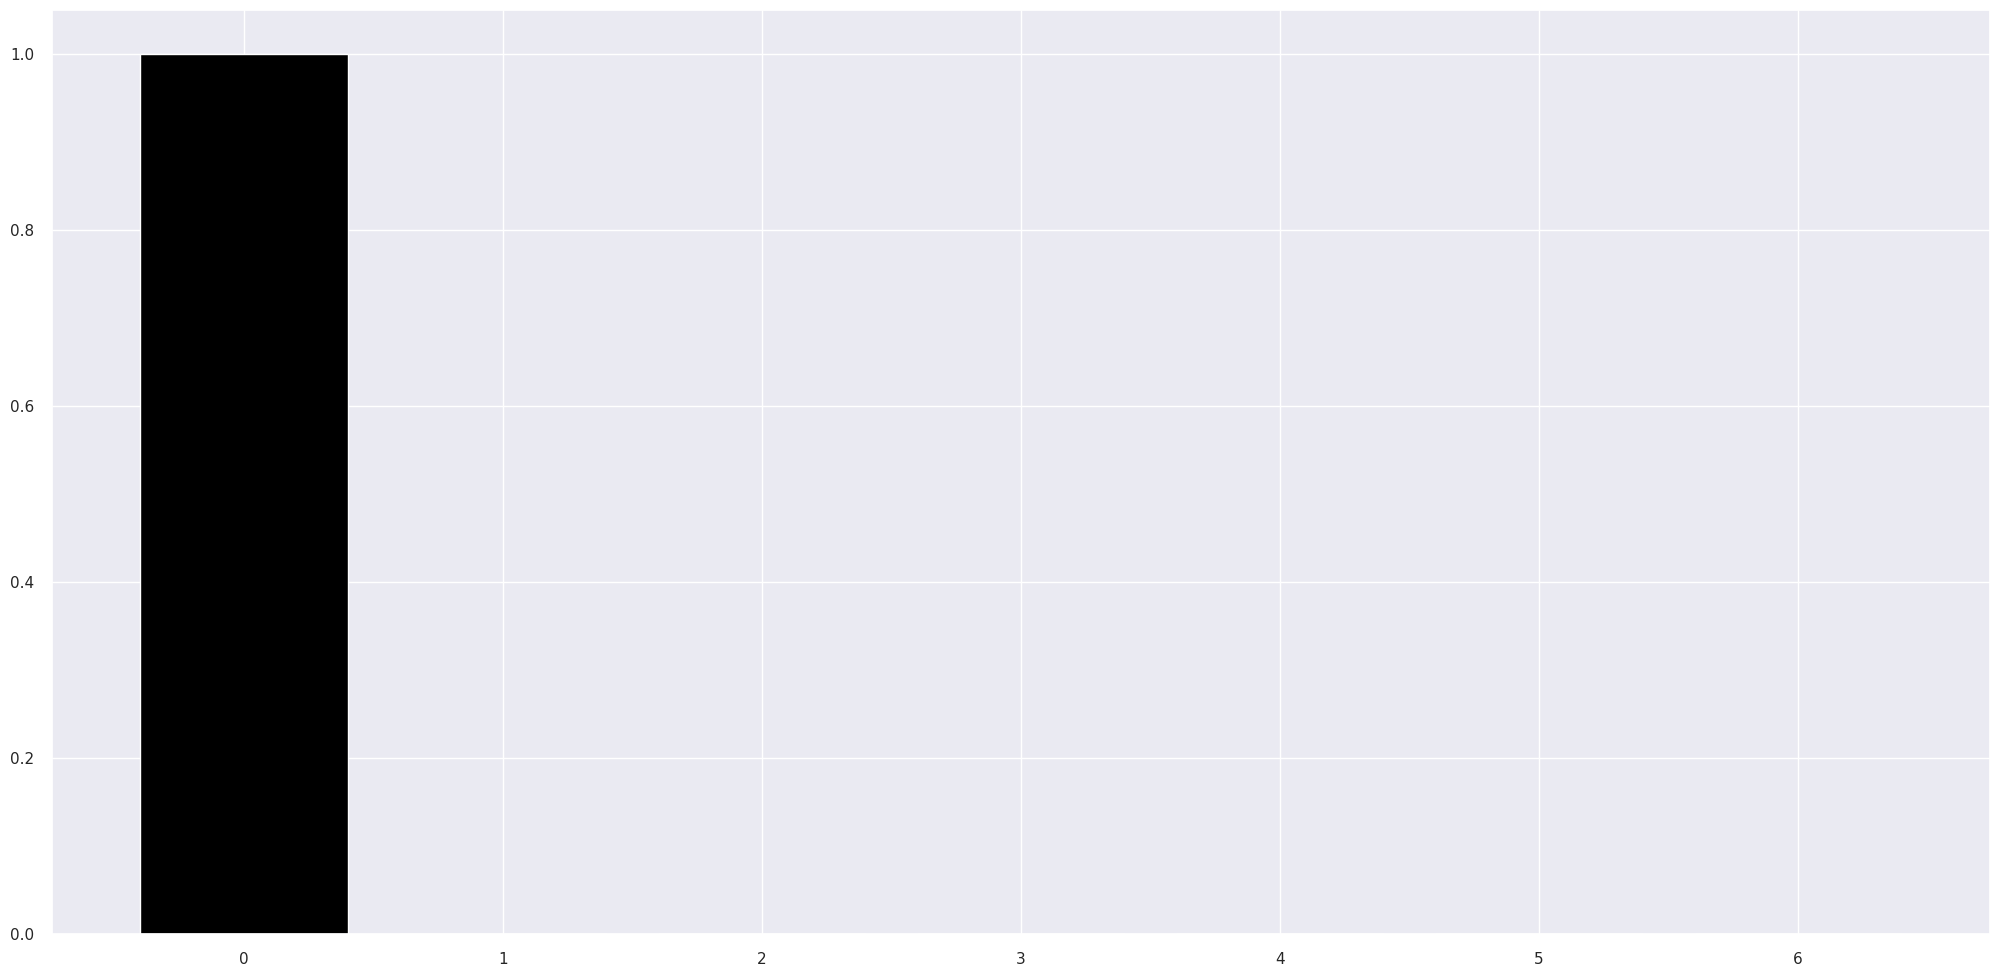

In [104]:
# Defining number o components for PCA as number of columns
pca = dc.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# Plot explained variables
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

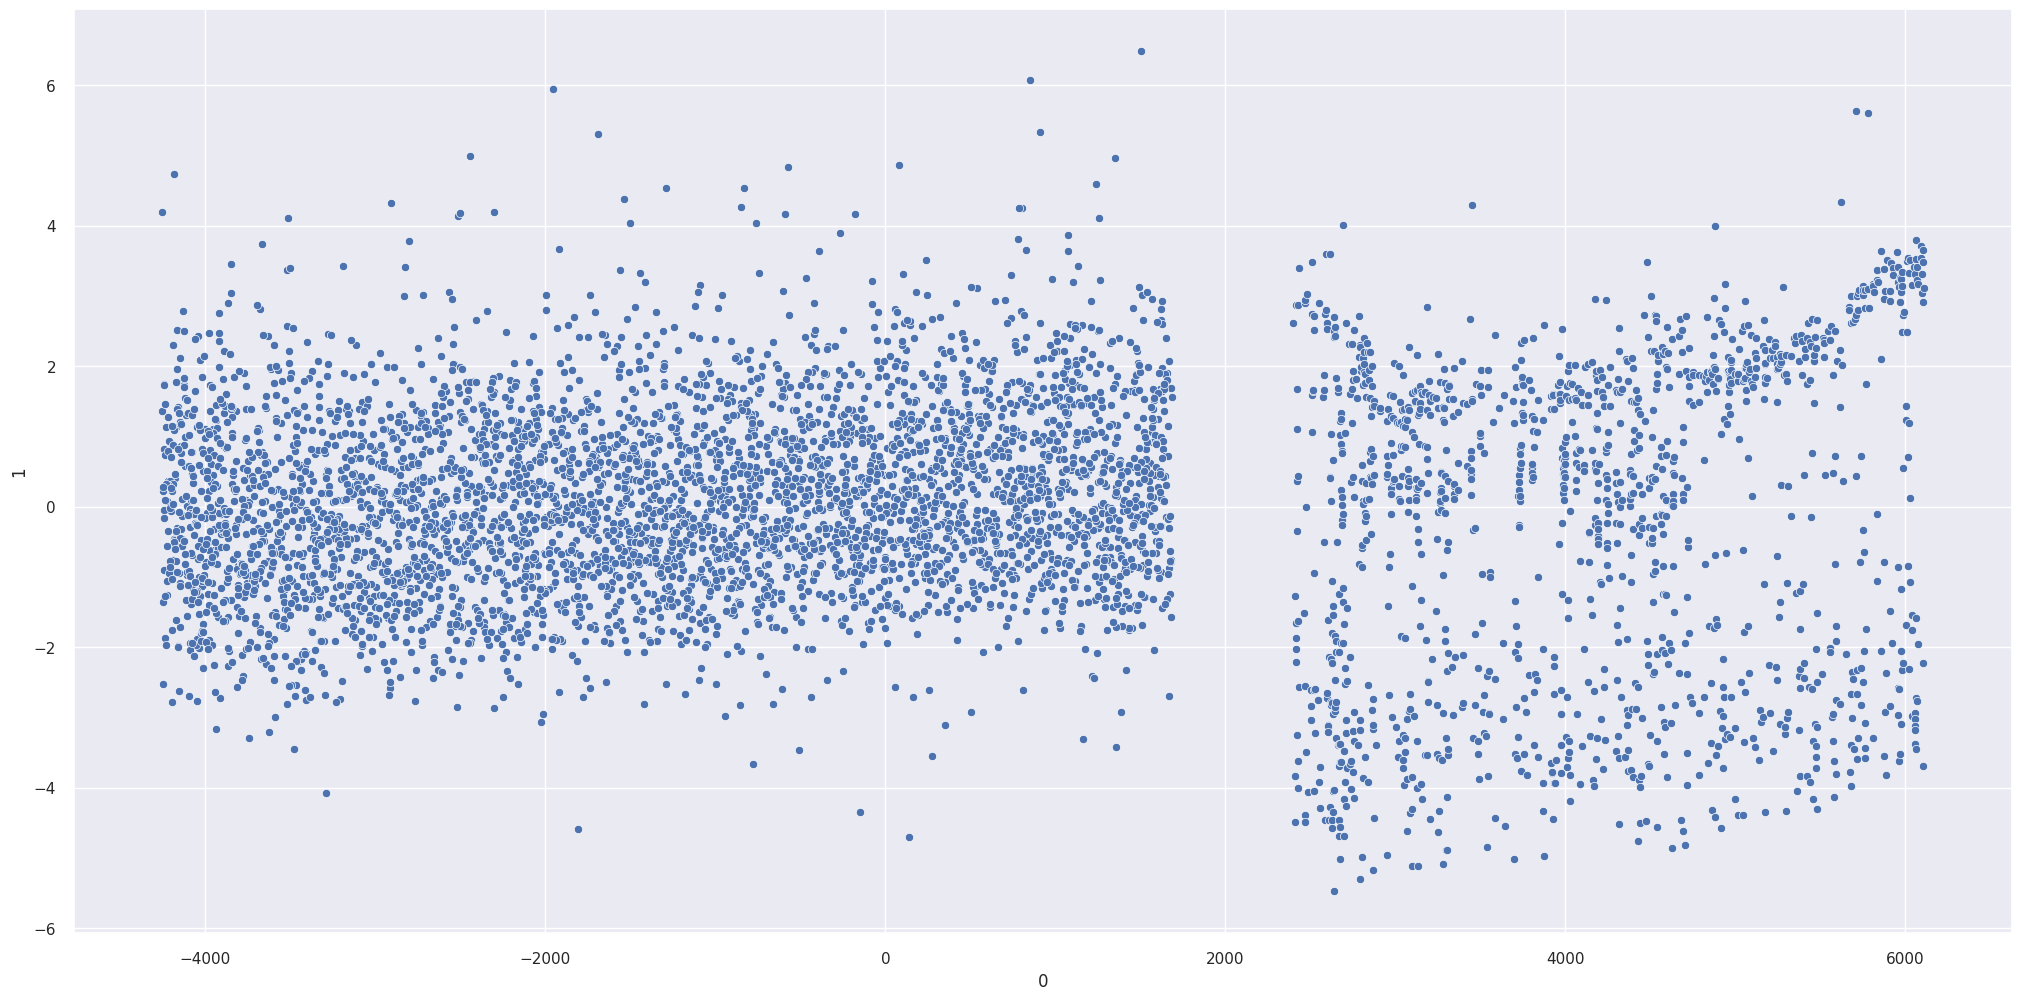

In [105]:
# Plot Component 0 and 1
sns.scatterplot(x=0, y=1, data=df_pca);

### 4.3.2 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

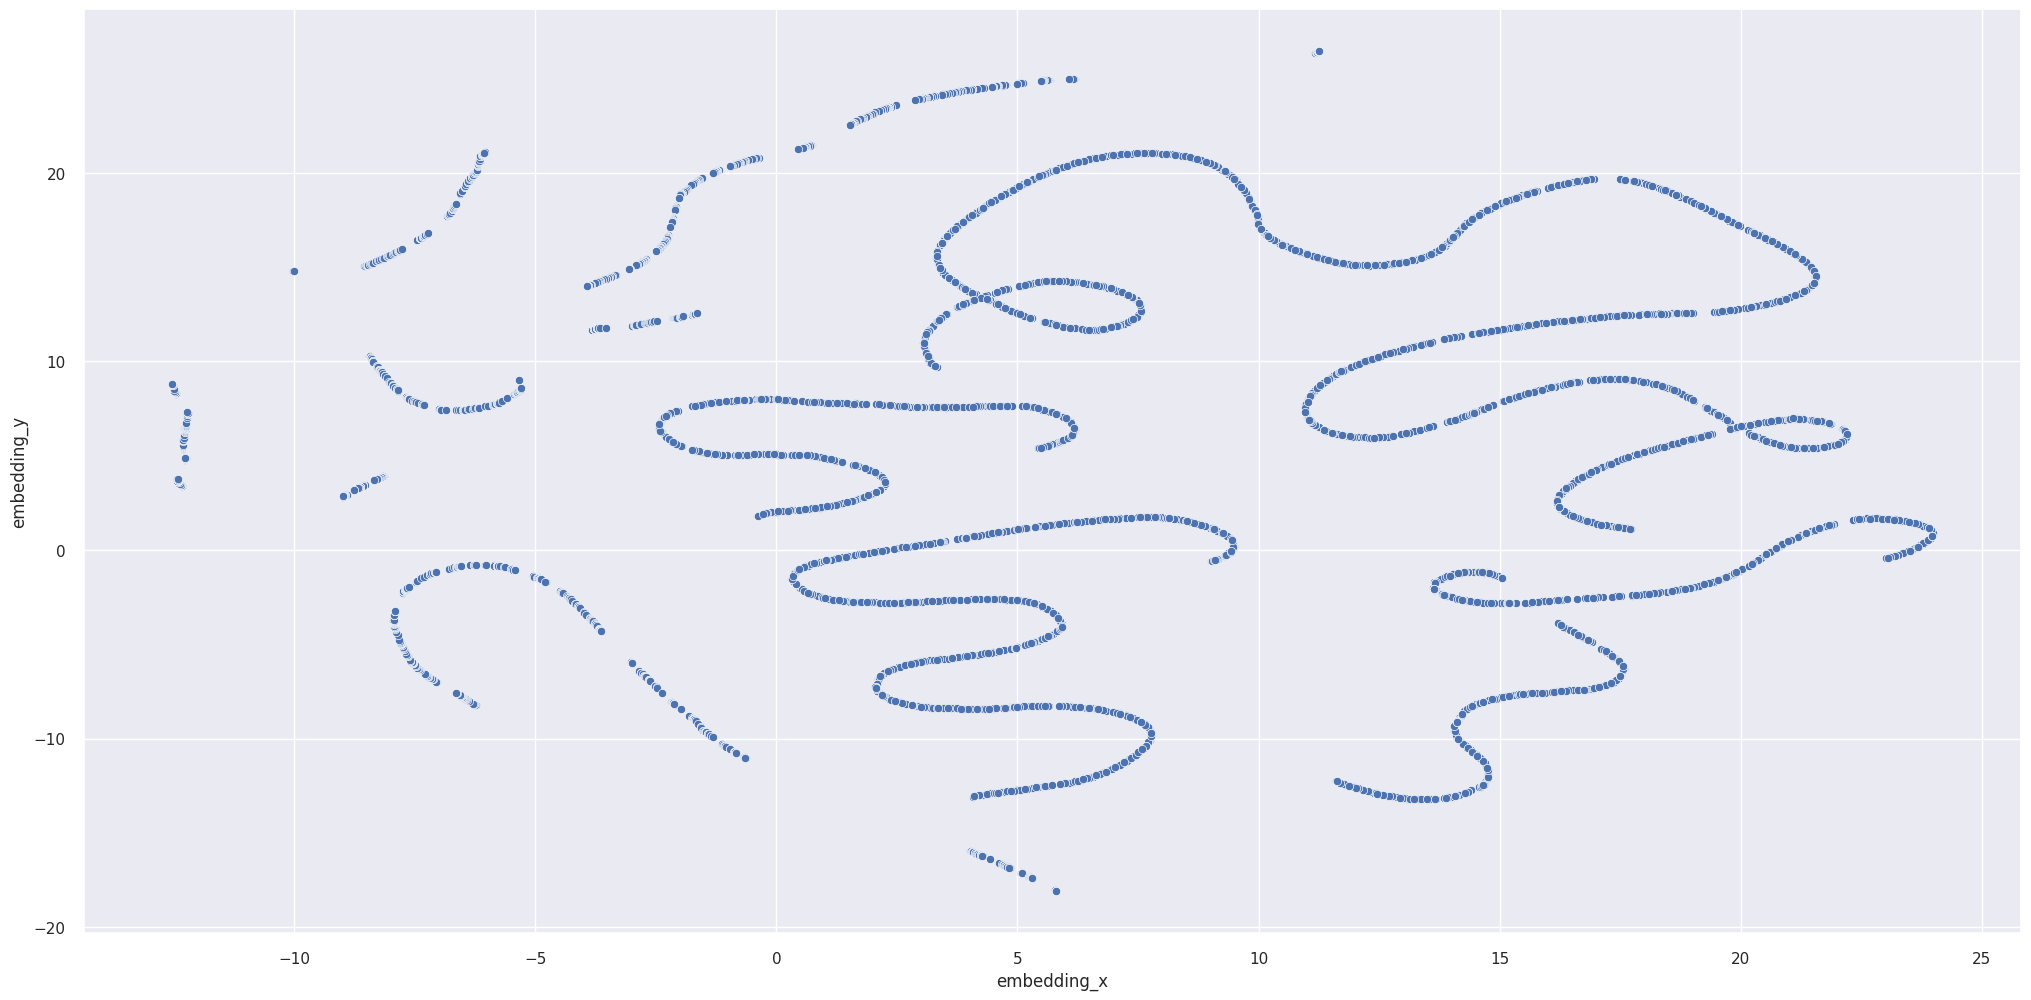

In [106]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

### 4.3.3 t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

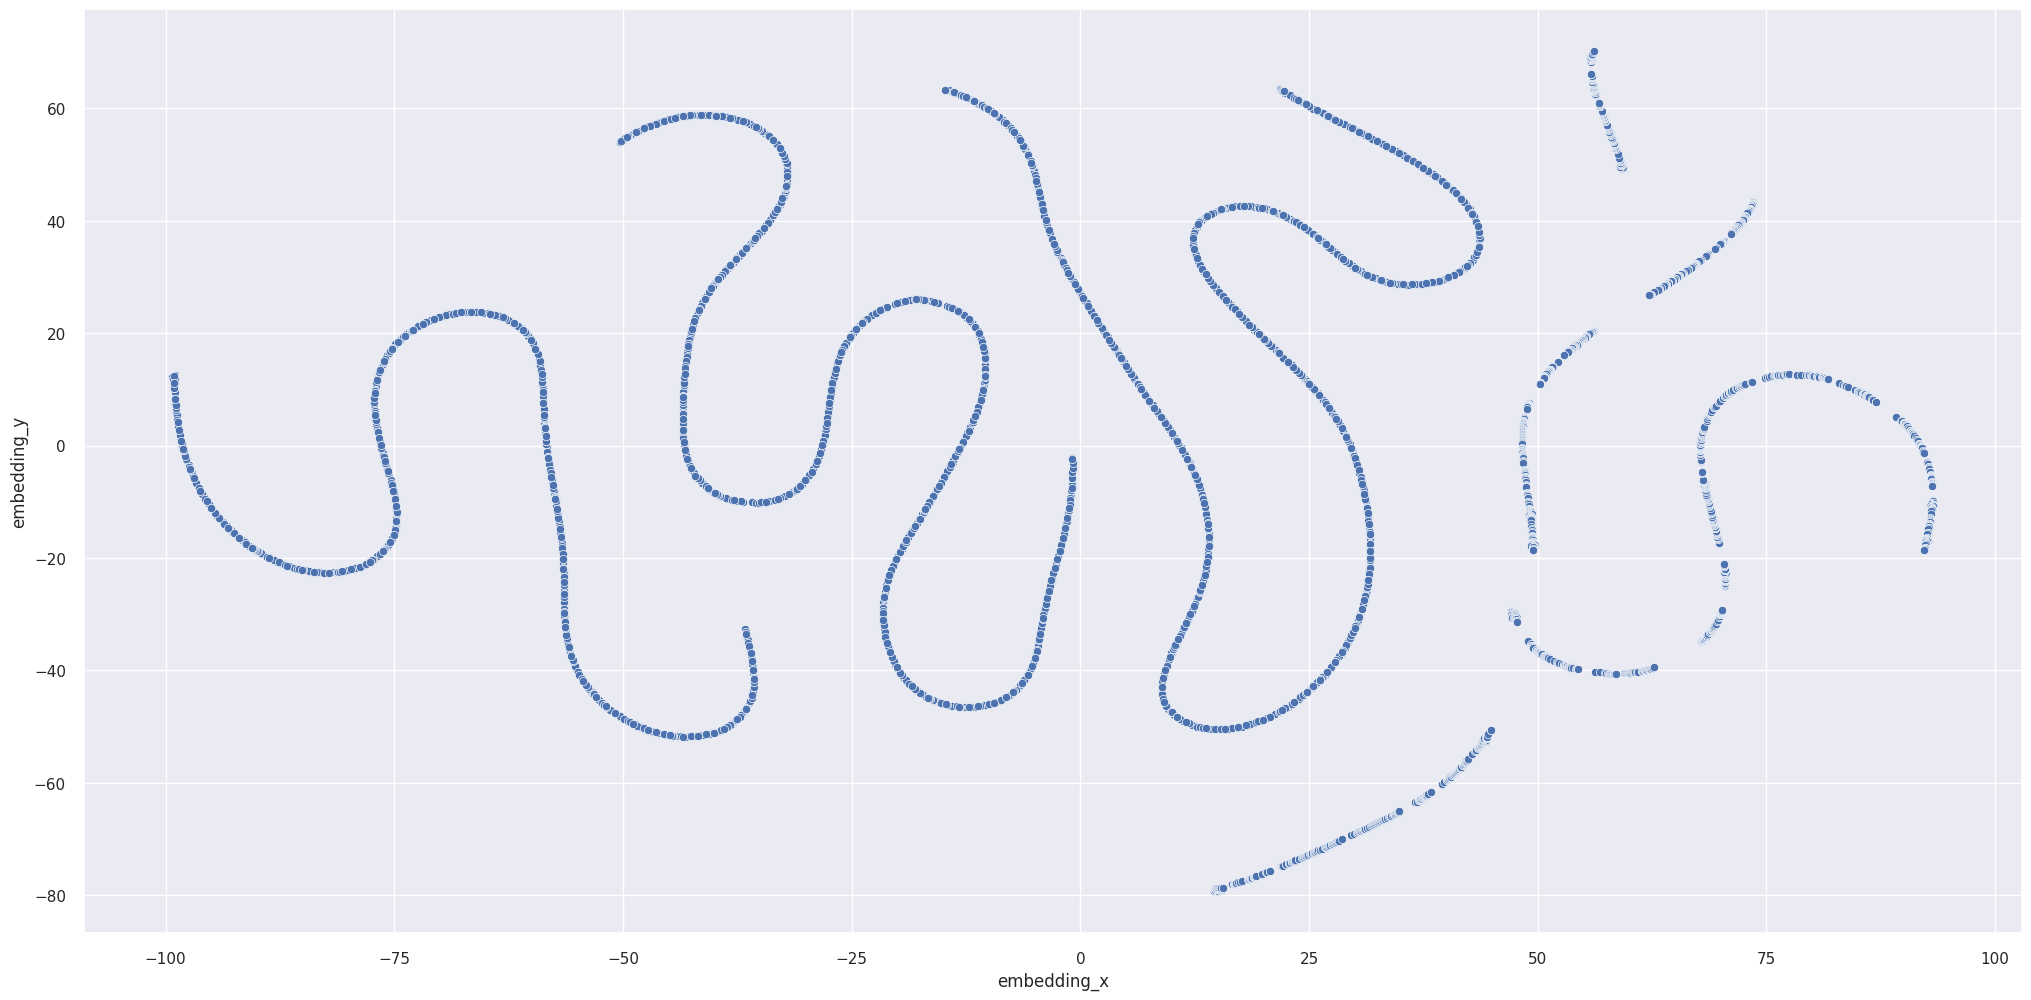

In [107]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

### 4.3.4 Tree-Based Embedding

In [108]:
# Decision Tree doesn't require Scalers
X = df43.drop(columns=['customer_id', 'gross_revenue'], axis=1)

# Defining Gross Revenue as target
y = df43['gross_revenue']

# Model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# Model training
rf_model.fit(X, y)

pickle.dump(rf_model, open('../src/model/rf_model.pkl', 'wb'))

# Leafs
df_leaf = pd.DataFrame(rf_model.apply(X))

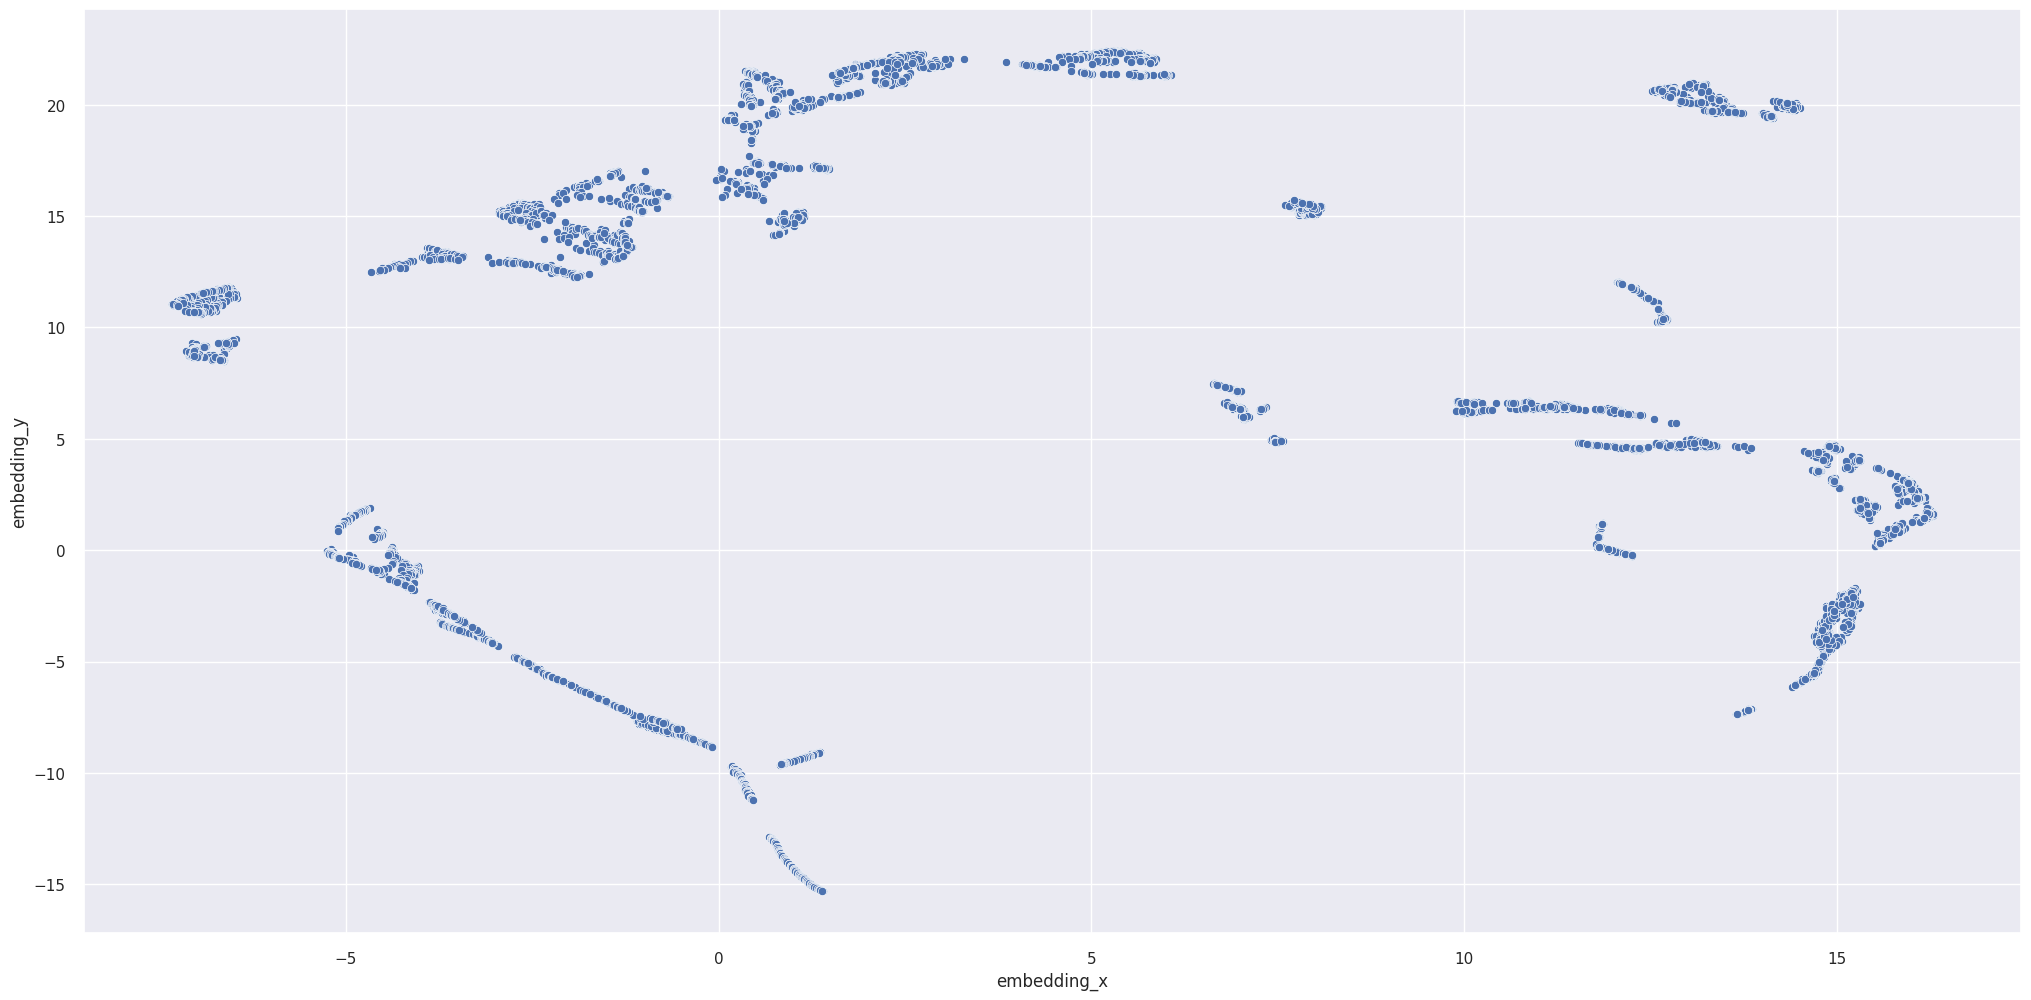

In [109]:
# with UMAP
reducer = umap.UMAP(random_state=42,
                    n_neighbors=170,
                    n_epochs=400,
                    metric='manhattan')

embedding = reducer.fit_transform(df_leaf)

pickle.dump(reducer, open('../src/features/umap_reducer.pkl', 'wb'))

# Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_tree);

# 5.0 DATA PREPARATION

In [110]:
df5 = df_ref[cols_selected].dropna().copy()

# 6.0 FEATURE SELECTION

In [111]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE-TUNNING 

In [112]:
# embedded dataset
df7 = df_tree.copy()

In [114]:
clusters = np.arange(2, 31, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

## 7.1 K-Means

In [115]:
kmeans_list = []
for k in clusters:
    # Model definition
    kmeans_model = c.KMeans(n_clusters=k, n_init=10, random_state=7)    

    # Model training
    kmeans_model.fit(df7)

    # Model predict
    labels = kmeans_model.predict(df7)

    # Model performance
    sil = m.silhouette_score(df7, labels, metric='euclidean')
    kmeans_list.append(sil)

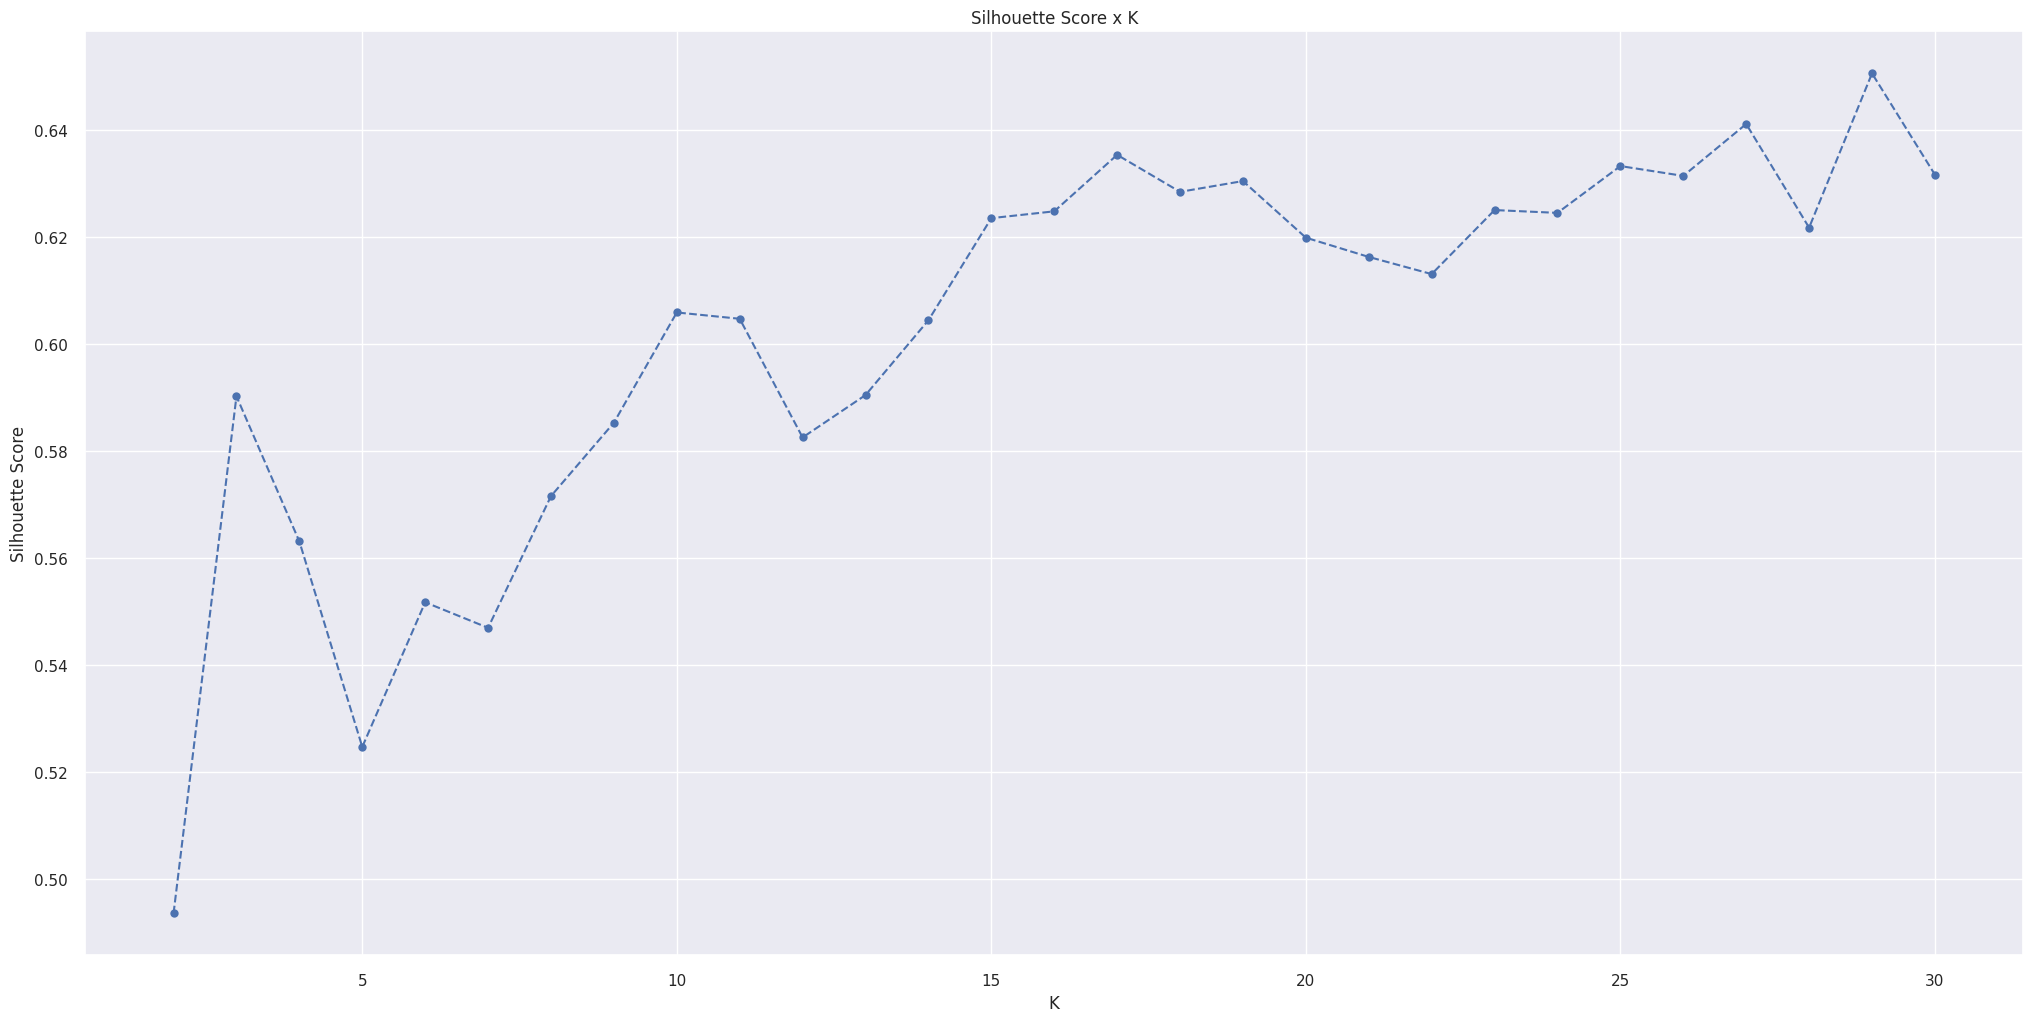

In [116]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K');

## 7.2 GMM

In [117]:
gmm_list = []
for k in clusters:
    # Model definition
    gmm_model = mx.GaussianMixture(n_components=k, random_state=7)

    # Model training
    gmm_model.fit(df7)

    # Model predict
    labels = gmm_model.predict(df7)

    # Model performance
    sil = m.silhouette_score(df7, labels, metric='euclidean')
    gmm_list.append(sil)

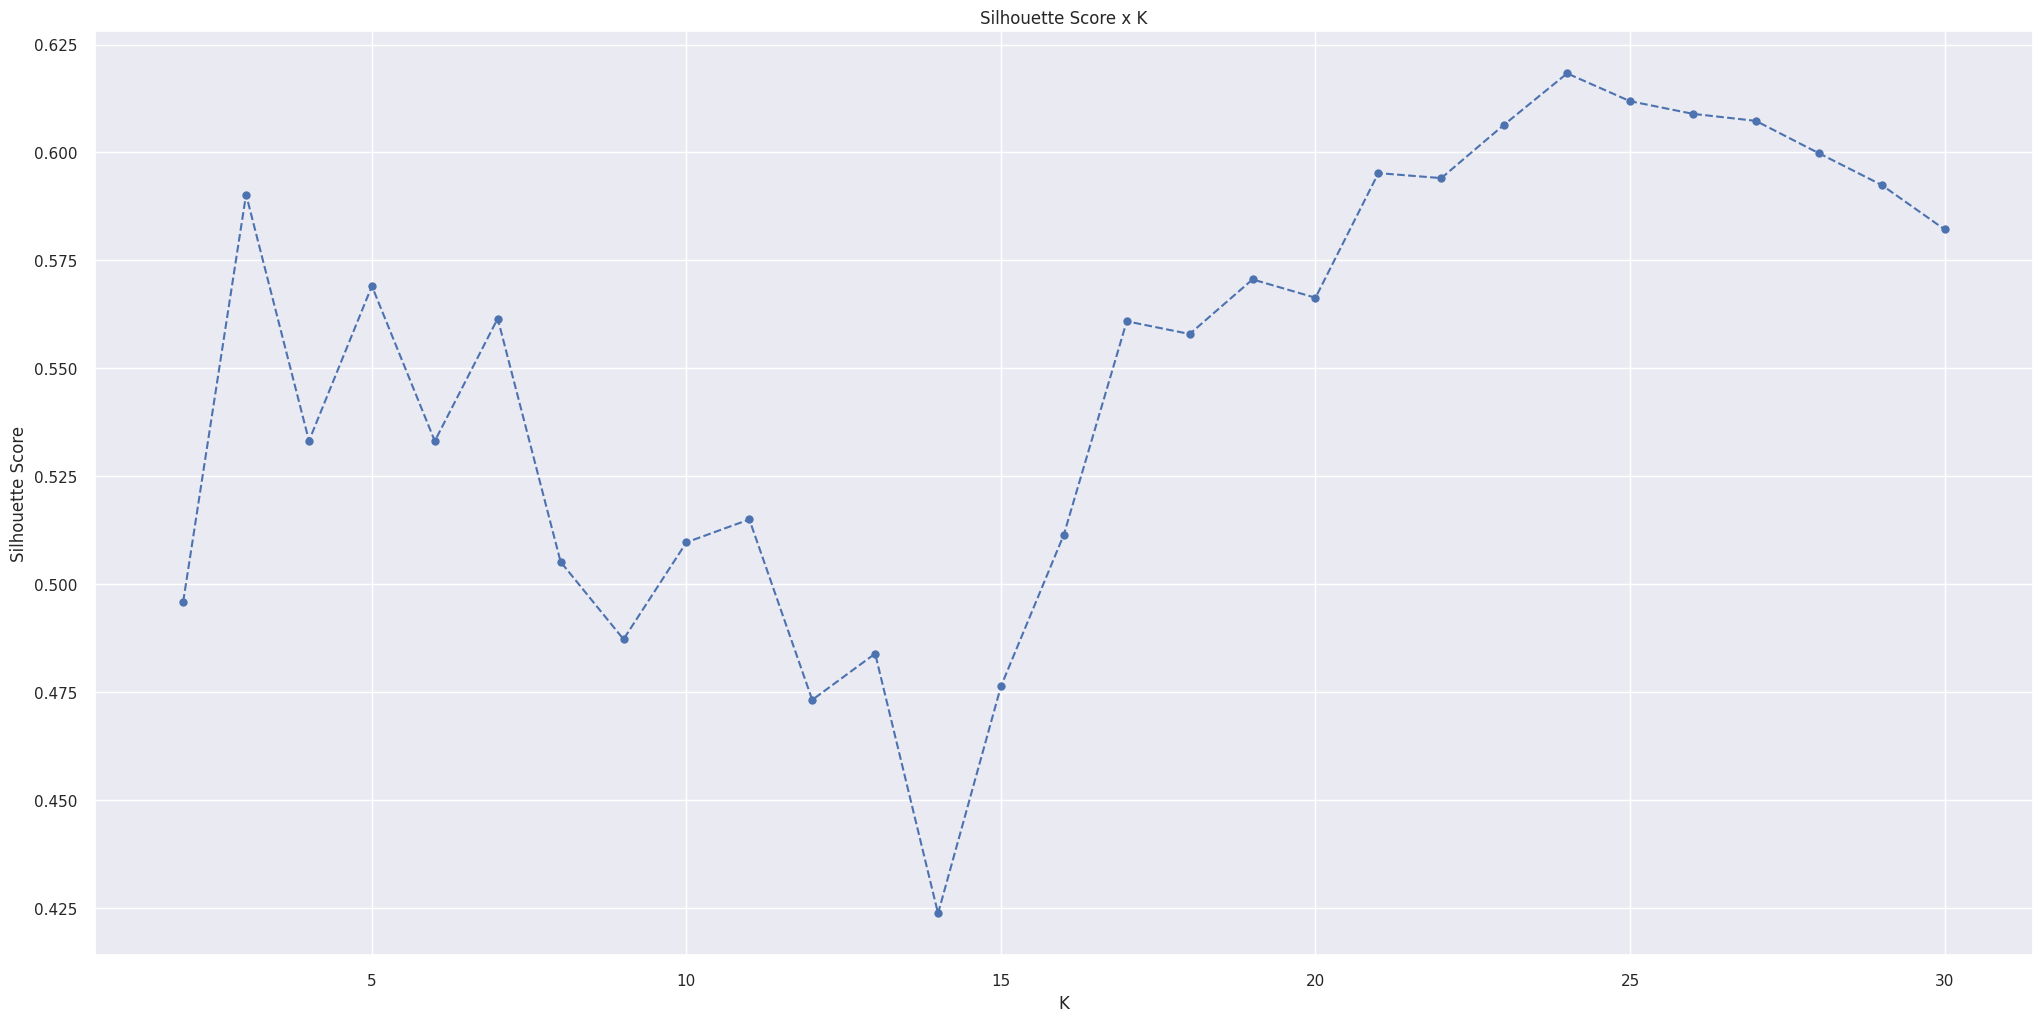

In [118]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K');

## 7.3 Hierarchical Clustering

### 7.3.1 Dendrograms

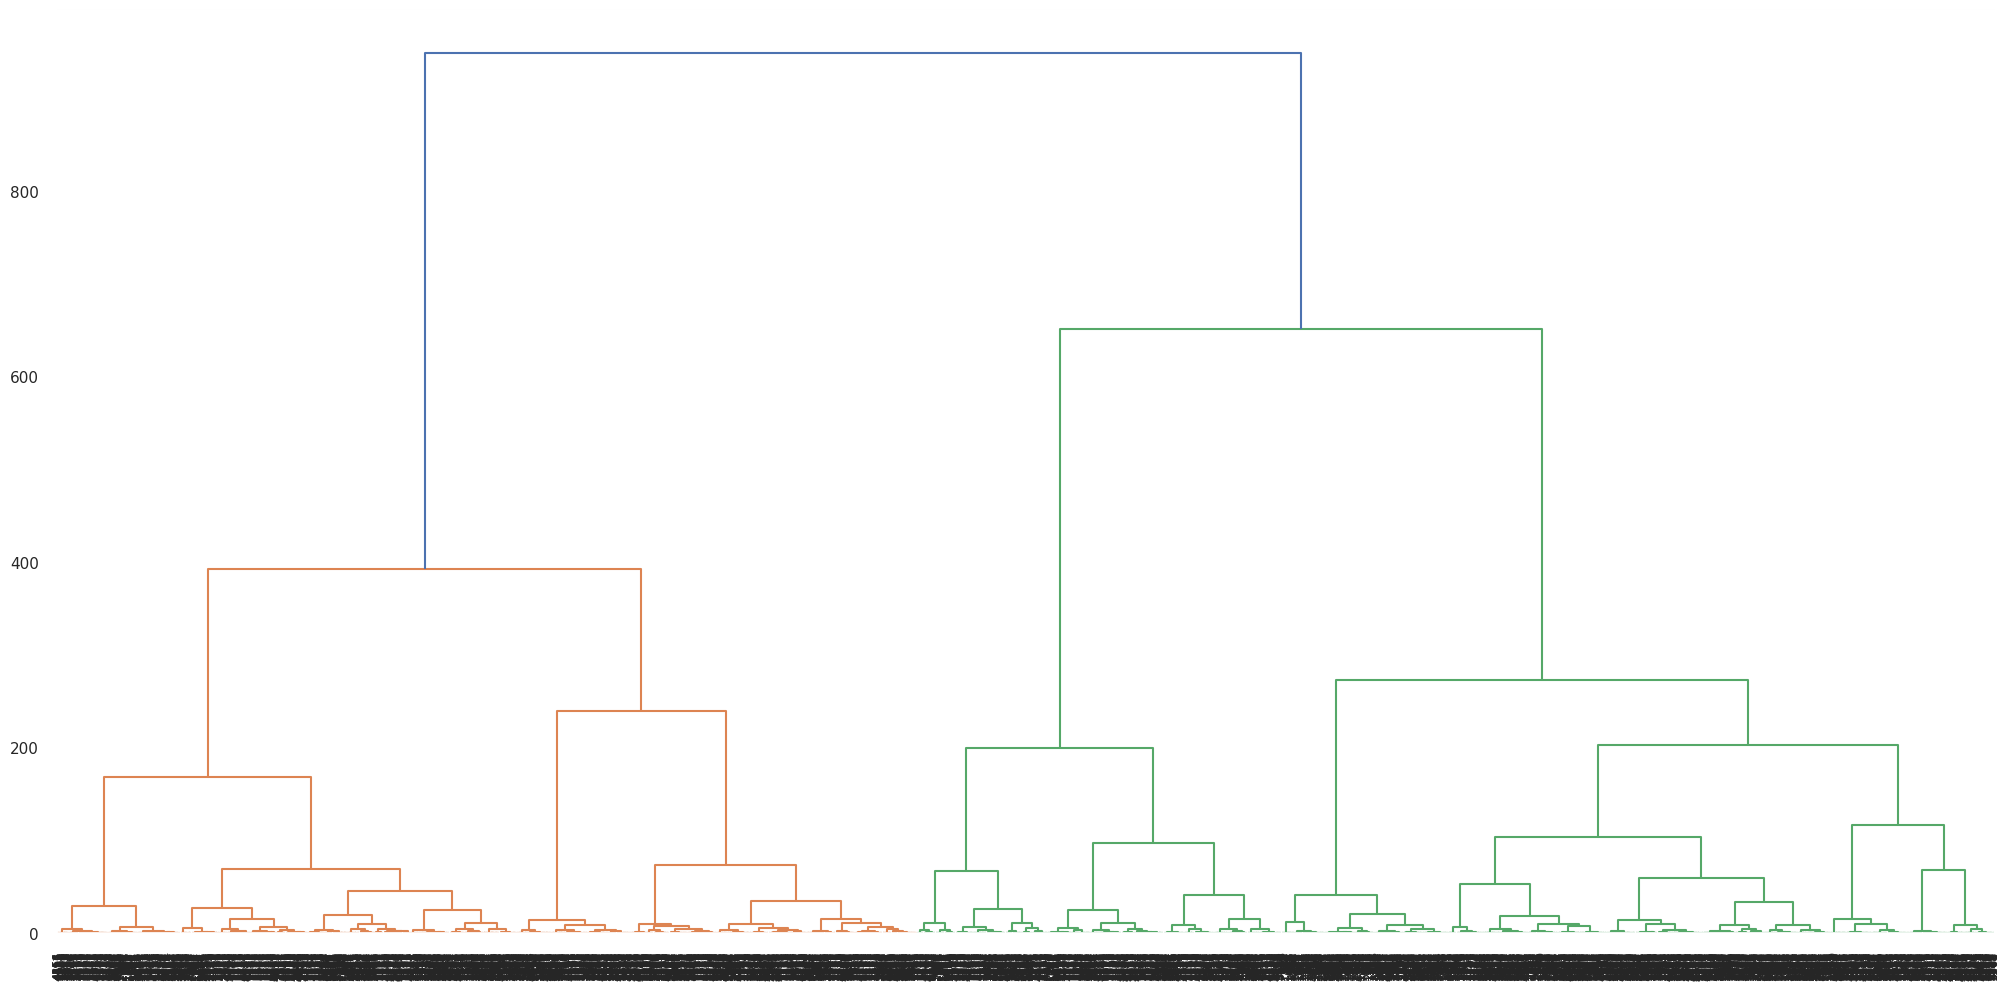

In [119]:
# Model definition and training
hc_model = hc.linkage(df7, 'ward')

hc.dendrogram(hc_model,
              leaf_rotation=90,
              leaf_font_size=8
             )
plt.show();

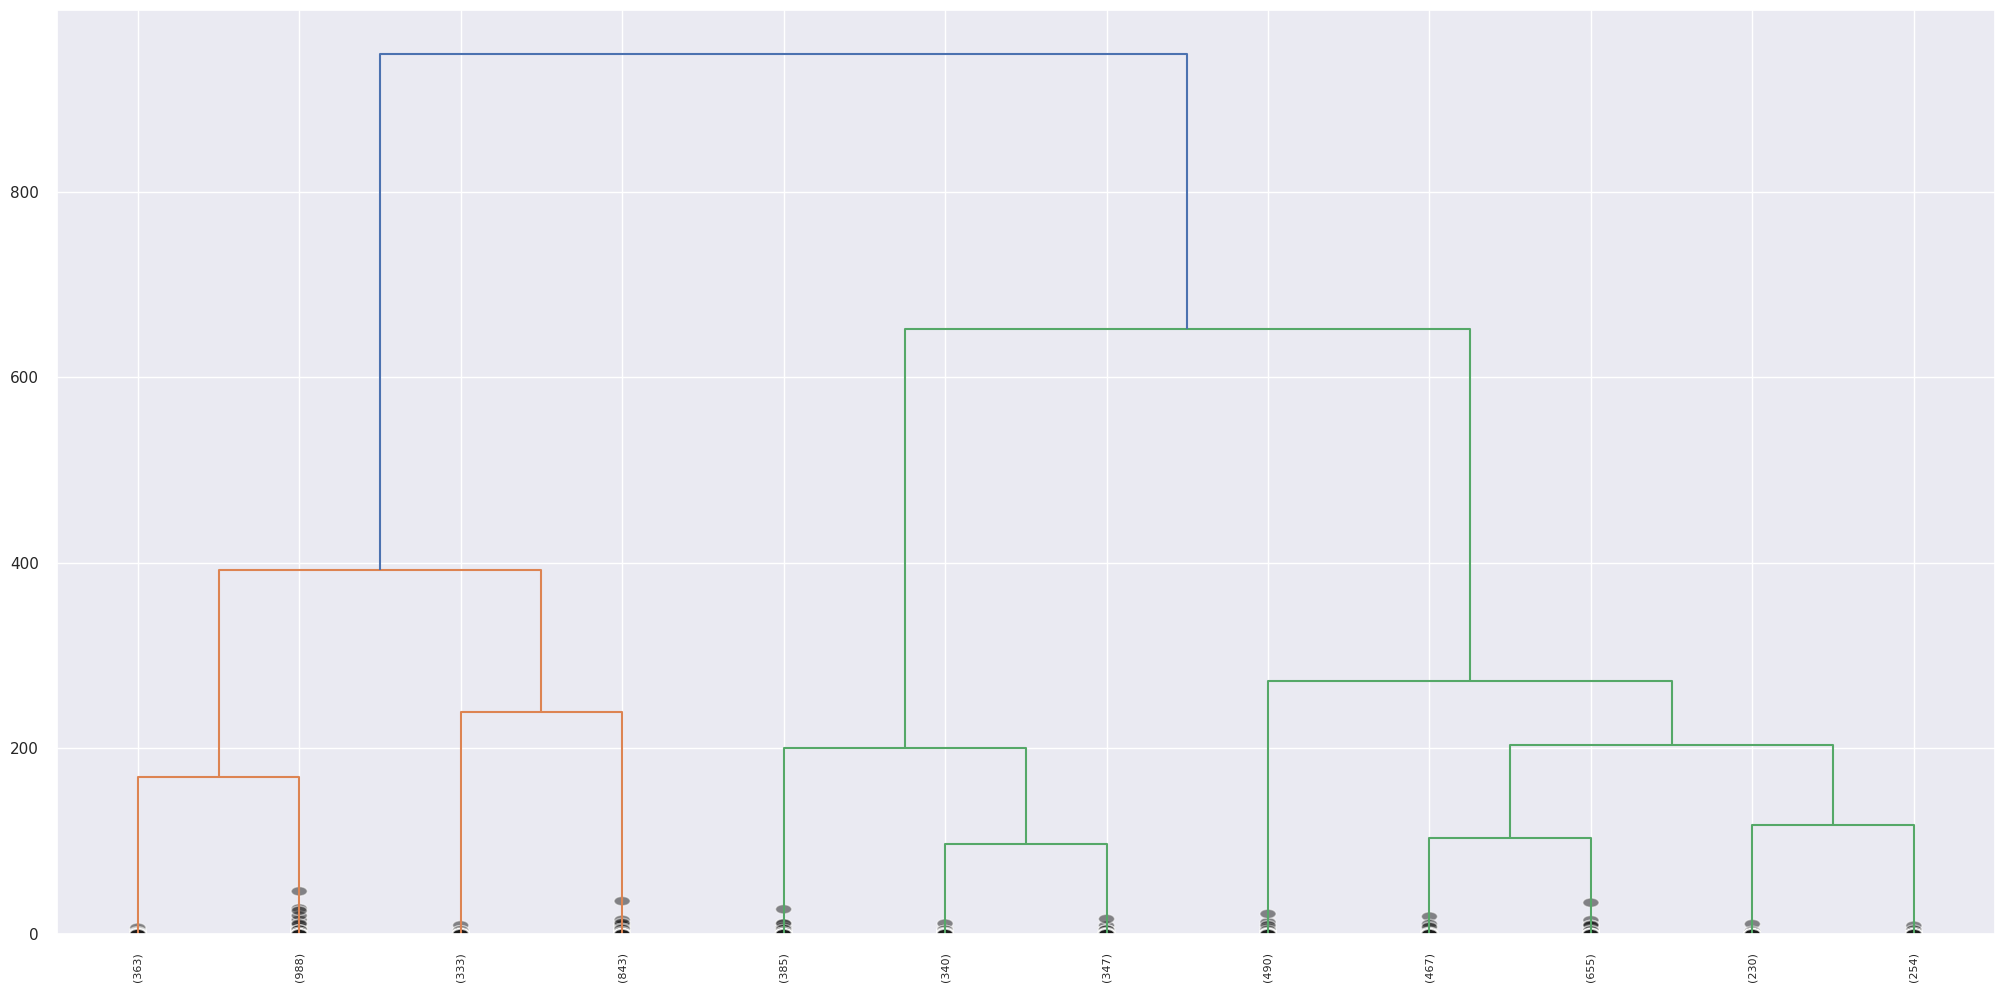

In [120]:
hc.dendrogram(hc_model,
              truncate_mode='lastp',
              p=12,
              leaf_rotation=90,
              leaf_font_size=8,
              show_contracted=True
             )
plt.show();

### 7.3.2 Silhouette Score

In [121]:
hc_list = []
for k in clusters:
    # Model prediction and training
    hc_model = hc.linkage(df7, 'ward')

    # Model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # Model performance
    sil = m.silhouette_score(df7, labels, metric='euclidean')
    hc_list.append(sil)

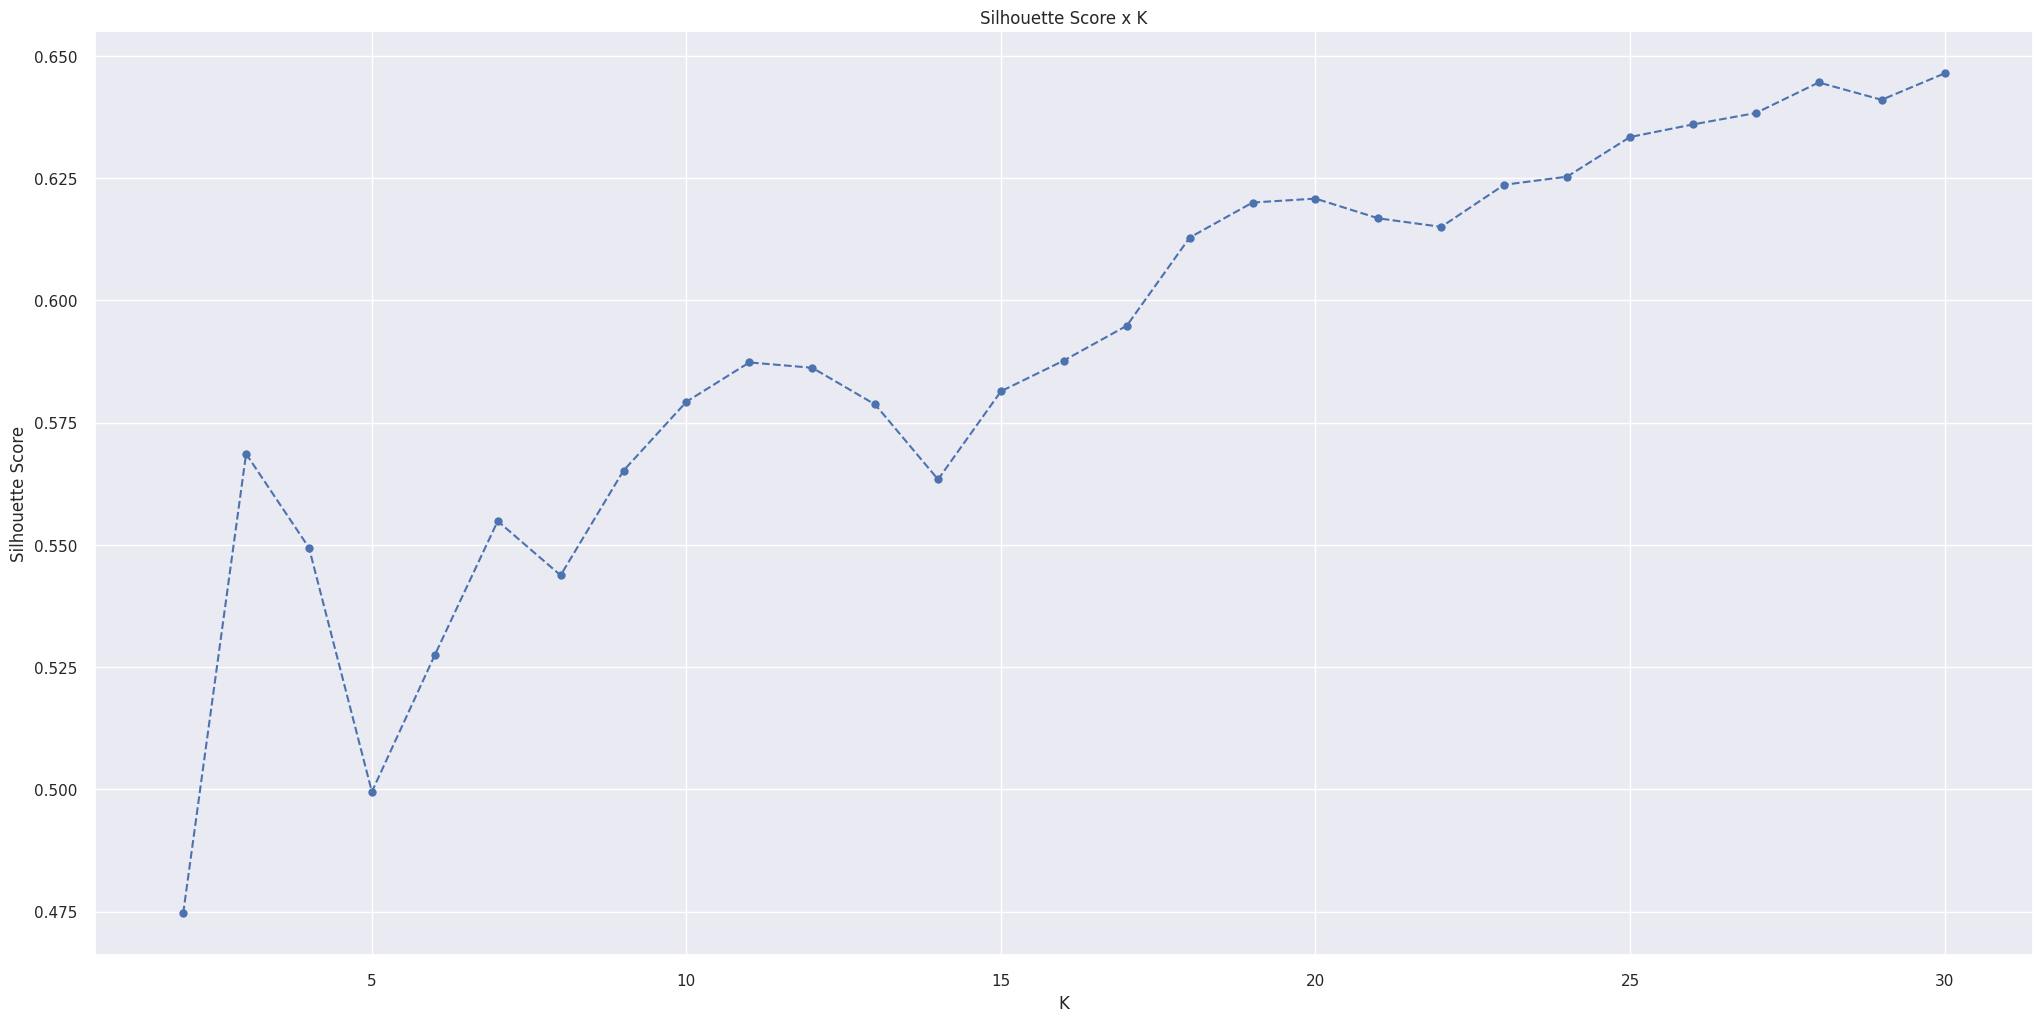

In [122]:
plt.plot(clusters, hc_list, linestyle='--', marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K');

## 7.4 DBSCAN

In [123]:
eps = 1
min_samples = 50

# Model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# Model training & predict
labels = dbscan_model.fit_predict(df7)

# Model performance
sil = m.silhouette_score(df7, labels, metric='euclidean')
print(f'Silhouette Score: {sil}')
print(f'Clusters: {unique(labels)}')

Silhouette Score: 0.4319230616092682
Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11]


In [124]:
# calculating the distances for each client
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(df7)
distances, indeces = neighbors.kneighbors(df7)

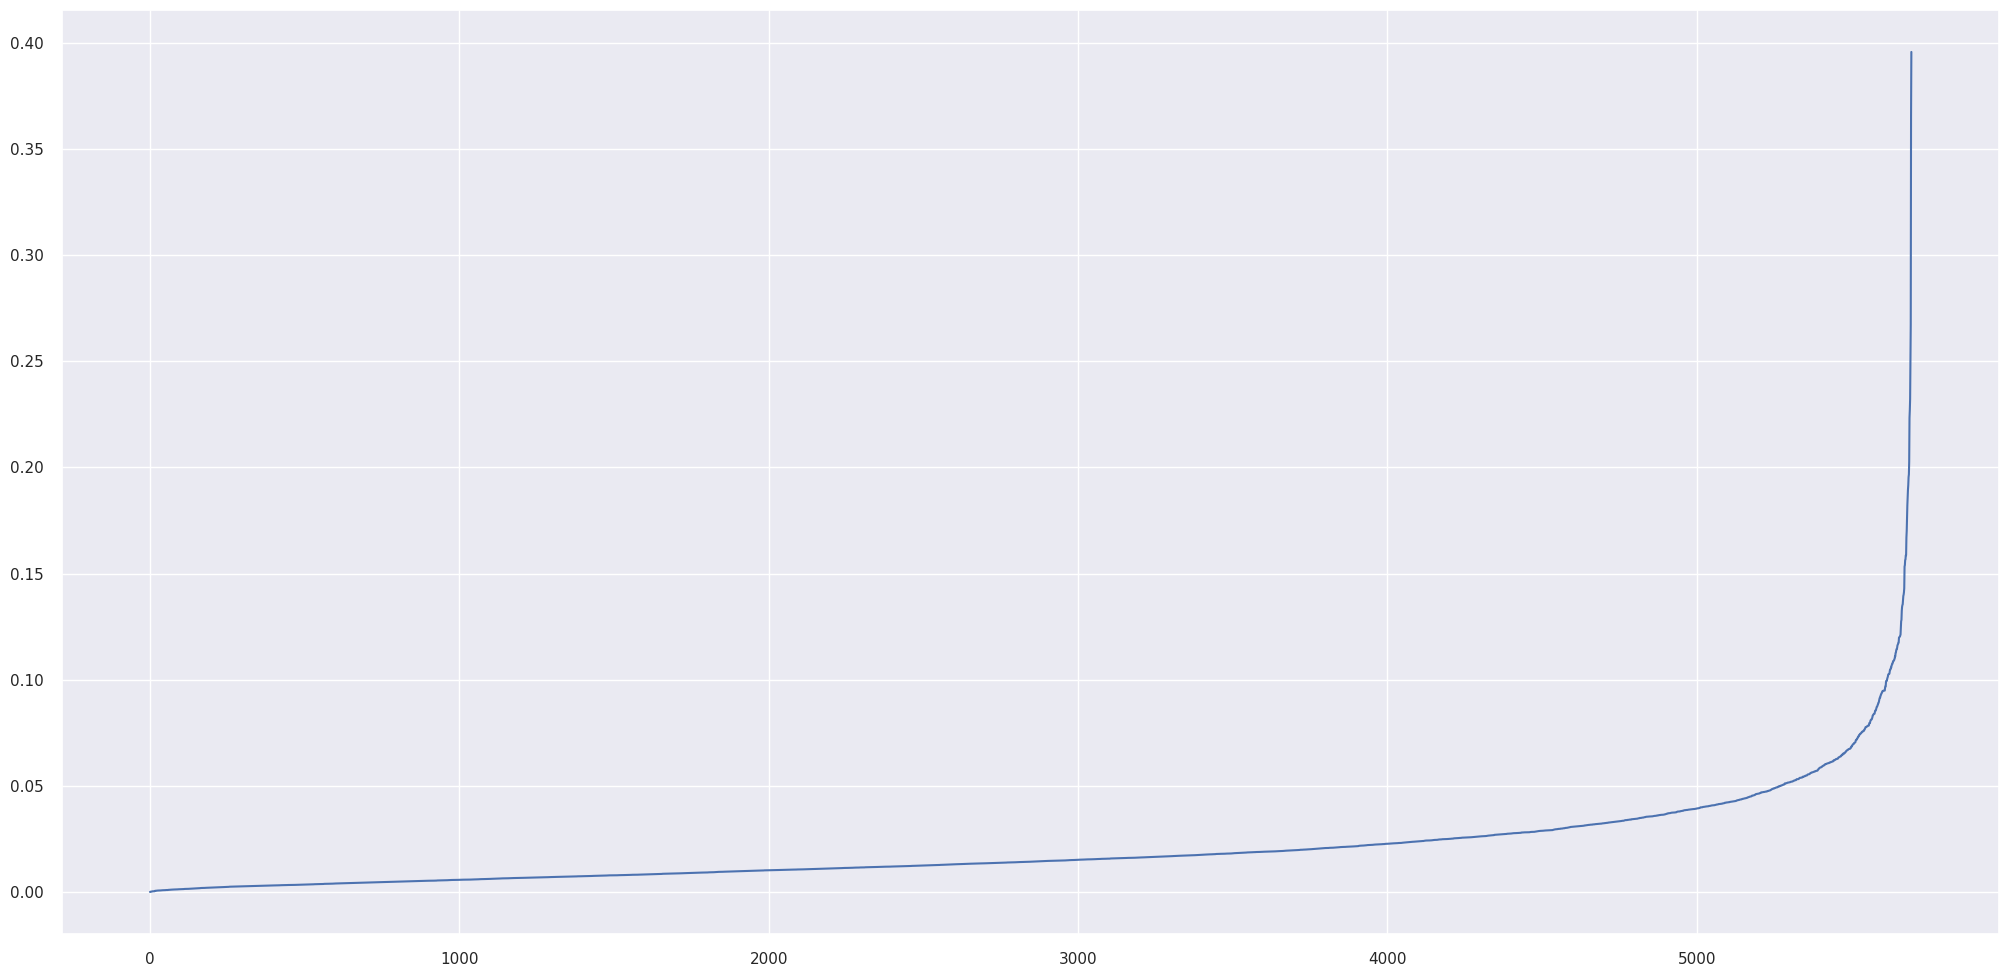

In [125]:
# sorting and ploting distance for elbow visualization
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

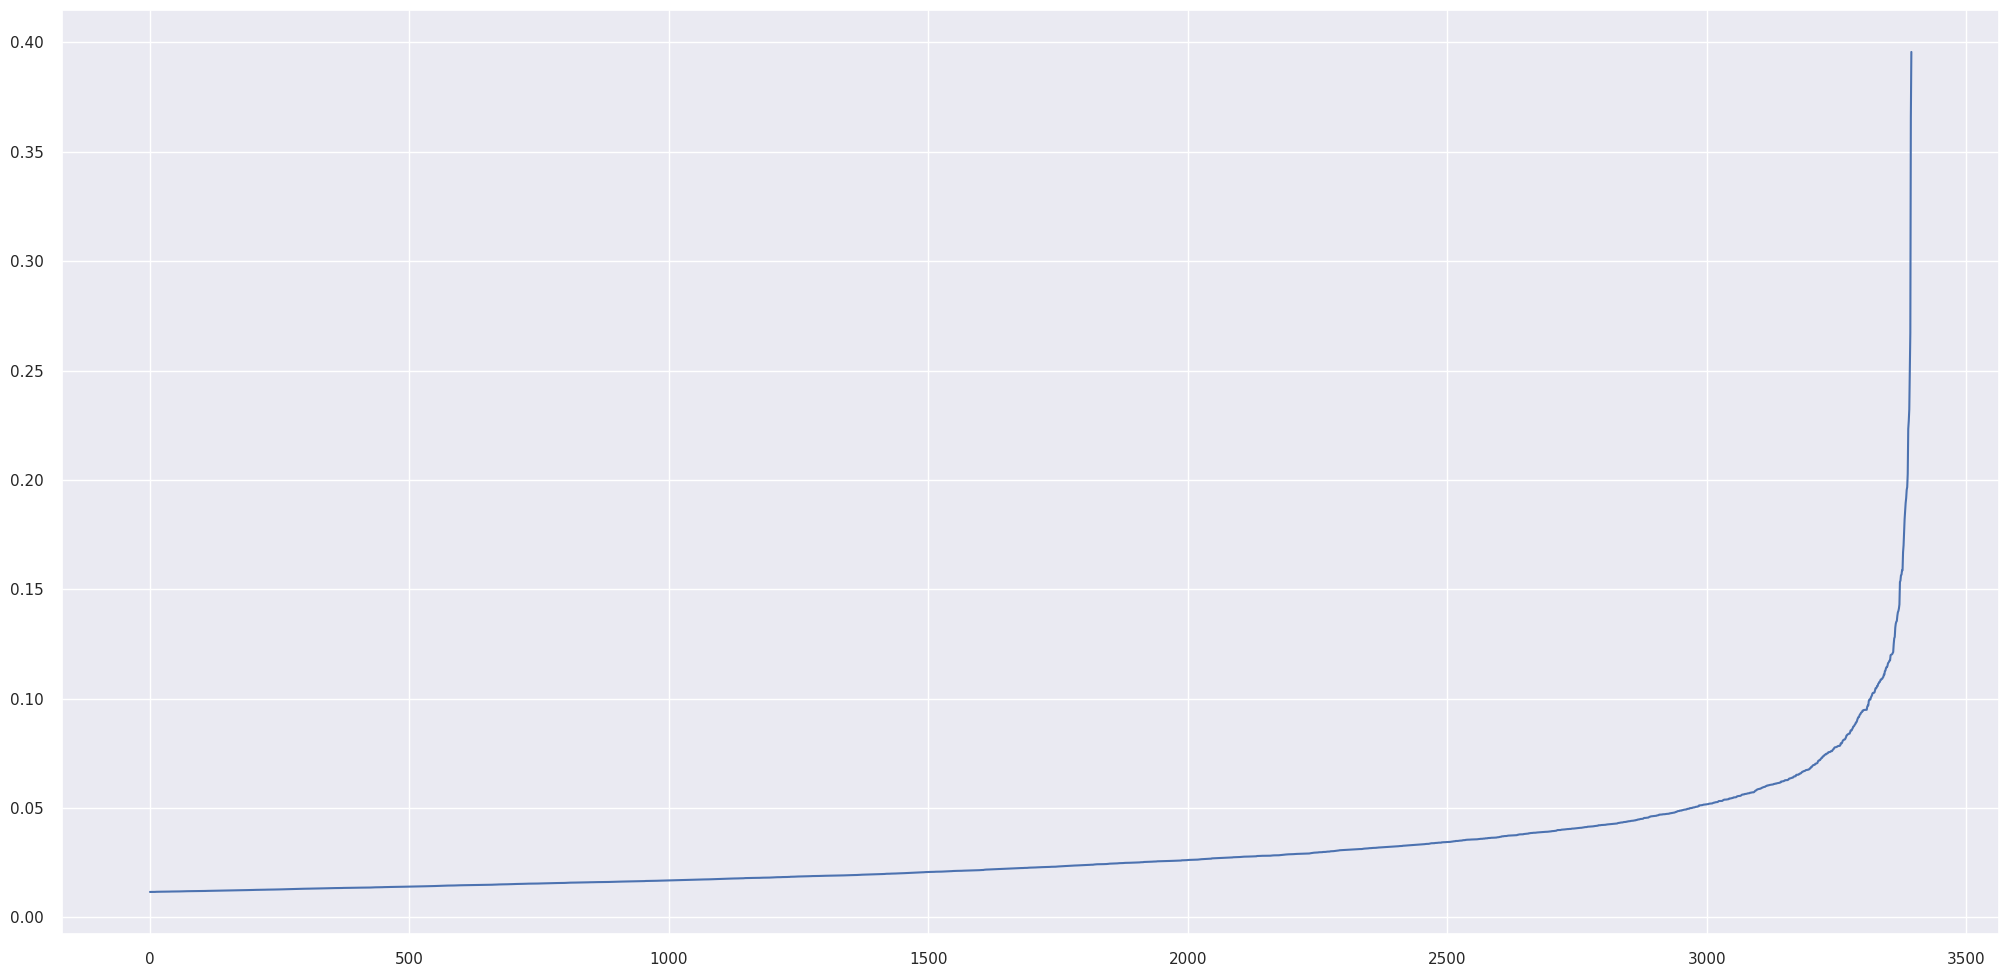

In [126]:
# zooming in for better visualization
plt.plot(distances[2300:])

## 7.5 Results

In [127]:
# Comparing Silhouette Scores
df_results = pd.DataFrame({'Kmeans': kmeans_list,
                           'GMM': gmm_list,
                           'H-Clustering': hc_list}
                           #'DBSCAN': dbscan_list
                           ).T
df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
Kmeans,0.493538,0.590264,0.563100,0.524673,0.551725,0.546950,0.571588,0.585317,0.605934,0.604753,0.582556,0.590483,0.604470,0.623576,0.624849,0.635416,0.628492,0.630512,0.619923,0.616319,0.613111,0.625085,0.624561,0.633315,0.631476,0.641186,0.621798,0.650649,0.631705
GMM,0.495960,0.590264,0.533213,0.569066,0.533163,0.561543,0.505192,0.487262,0.509706,0.515014,0.473220,0.483936,0.423777,0.476362,0.511497,0.560904,0.557959,0.570604,0.566356,0.595222,0.594059,0.606448,0.618315,0.611880,0.608947,0.607320,0.599838,0.592472,0.582195
H-Clustering,0.474618,0.568603,0.549391,0.499489,0.527453,0.554845,0.543756,0.565172,0.579254,0.587293,0.586199,0.578693,0.563366,0.581395,0.587683,0.594797,0.612829,0.619993,0.620797,0.616757,0.615021,0.623628,0.625287,0.633391,0.635964,0.638300,0.644548,0.641000,0.646405


## 7.6 Silhouette Analysis

### 7.6.1 K-Means

IndexError: index 3 is out of bounds for axis 0 with size 3

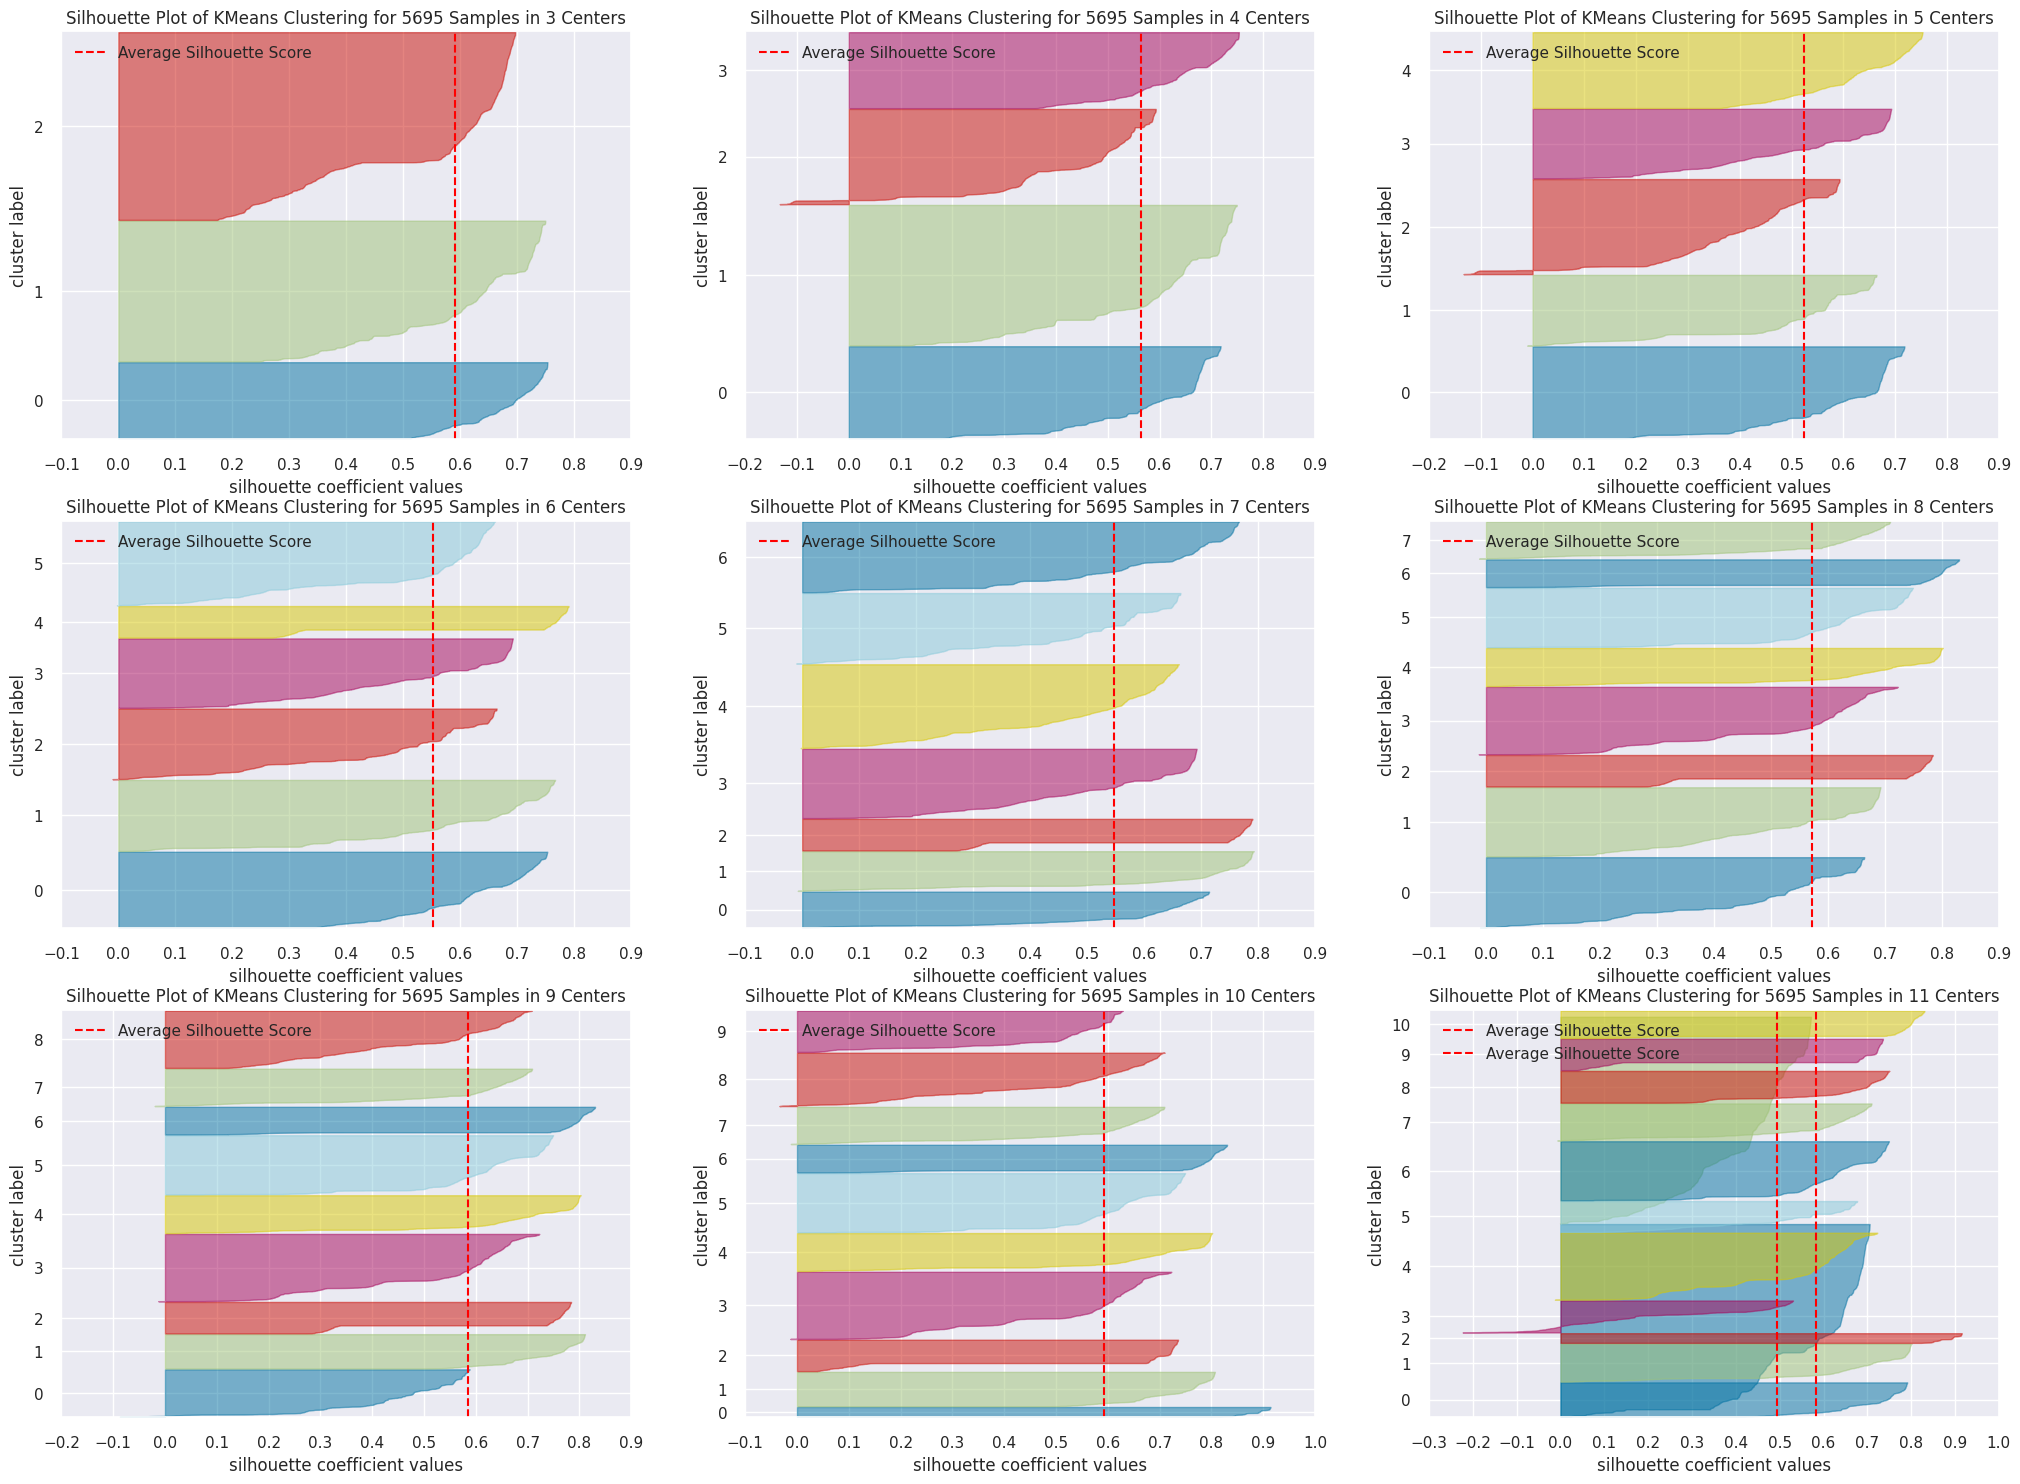

In [130]:
fig, ax = plt.subplots(3, 3, figsize=(25,18))
                      
for k in clusters:
    # Model definition
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    
    q, mod = divmod(k, 3)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

### 7.6.2 GMM

For k: 2. Silhouette Score: 0.49595972895622253
For k: 3. Silhouette Score: 0.5902636051177979
For k: 4. Silhouette Score: 0.5048366785049438
For k: 5. Silhouette Score: 0.5699050426483154
For k: 6. Silhouette Score: 0.4616355299949646
For k: 7. Silhouette Score: 0.5424571633338928
For k: 8. Silhouette Score: 0.5022597312927246
For k: 9. Silhouette Score: 0.5233134627342224
For k: 10. Silhouette Score: 0.5577669739723206
For k: 11. Silhouette Score: 0.5113134384155273


IndexError: index 3 is out of bounds for axis 0 with size 3

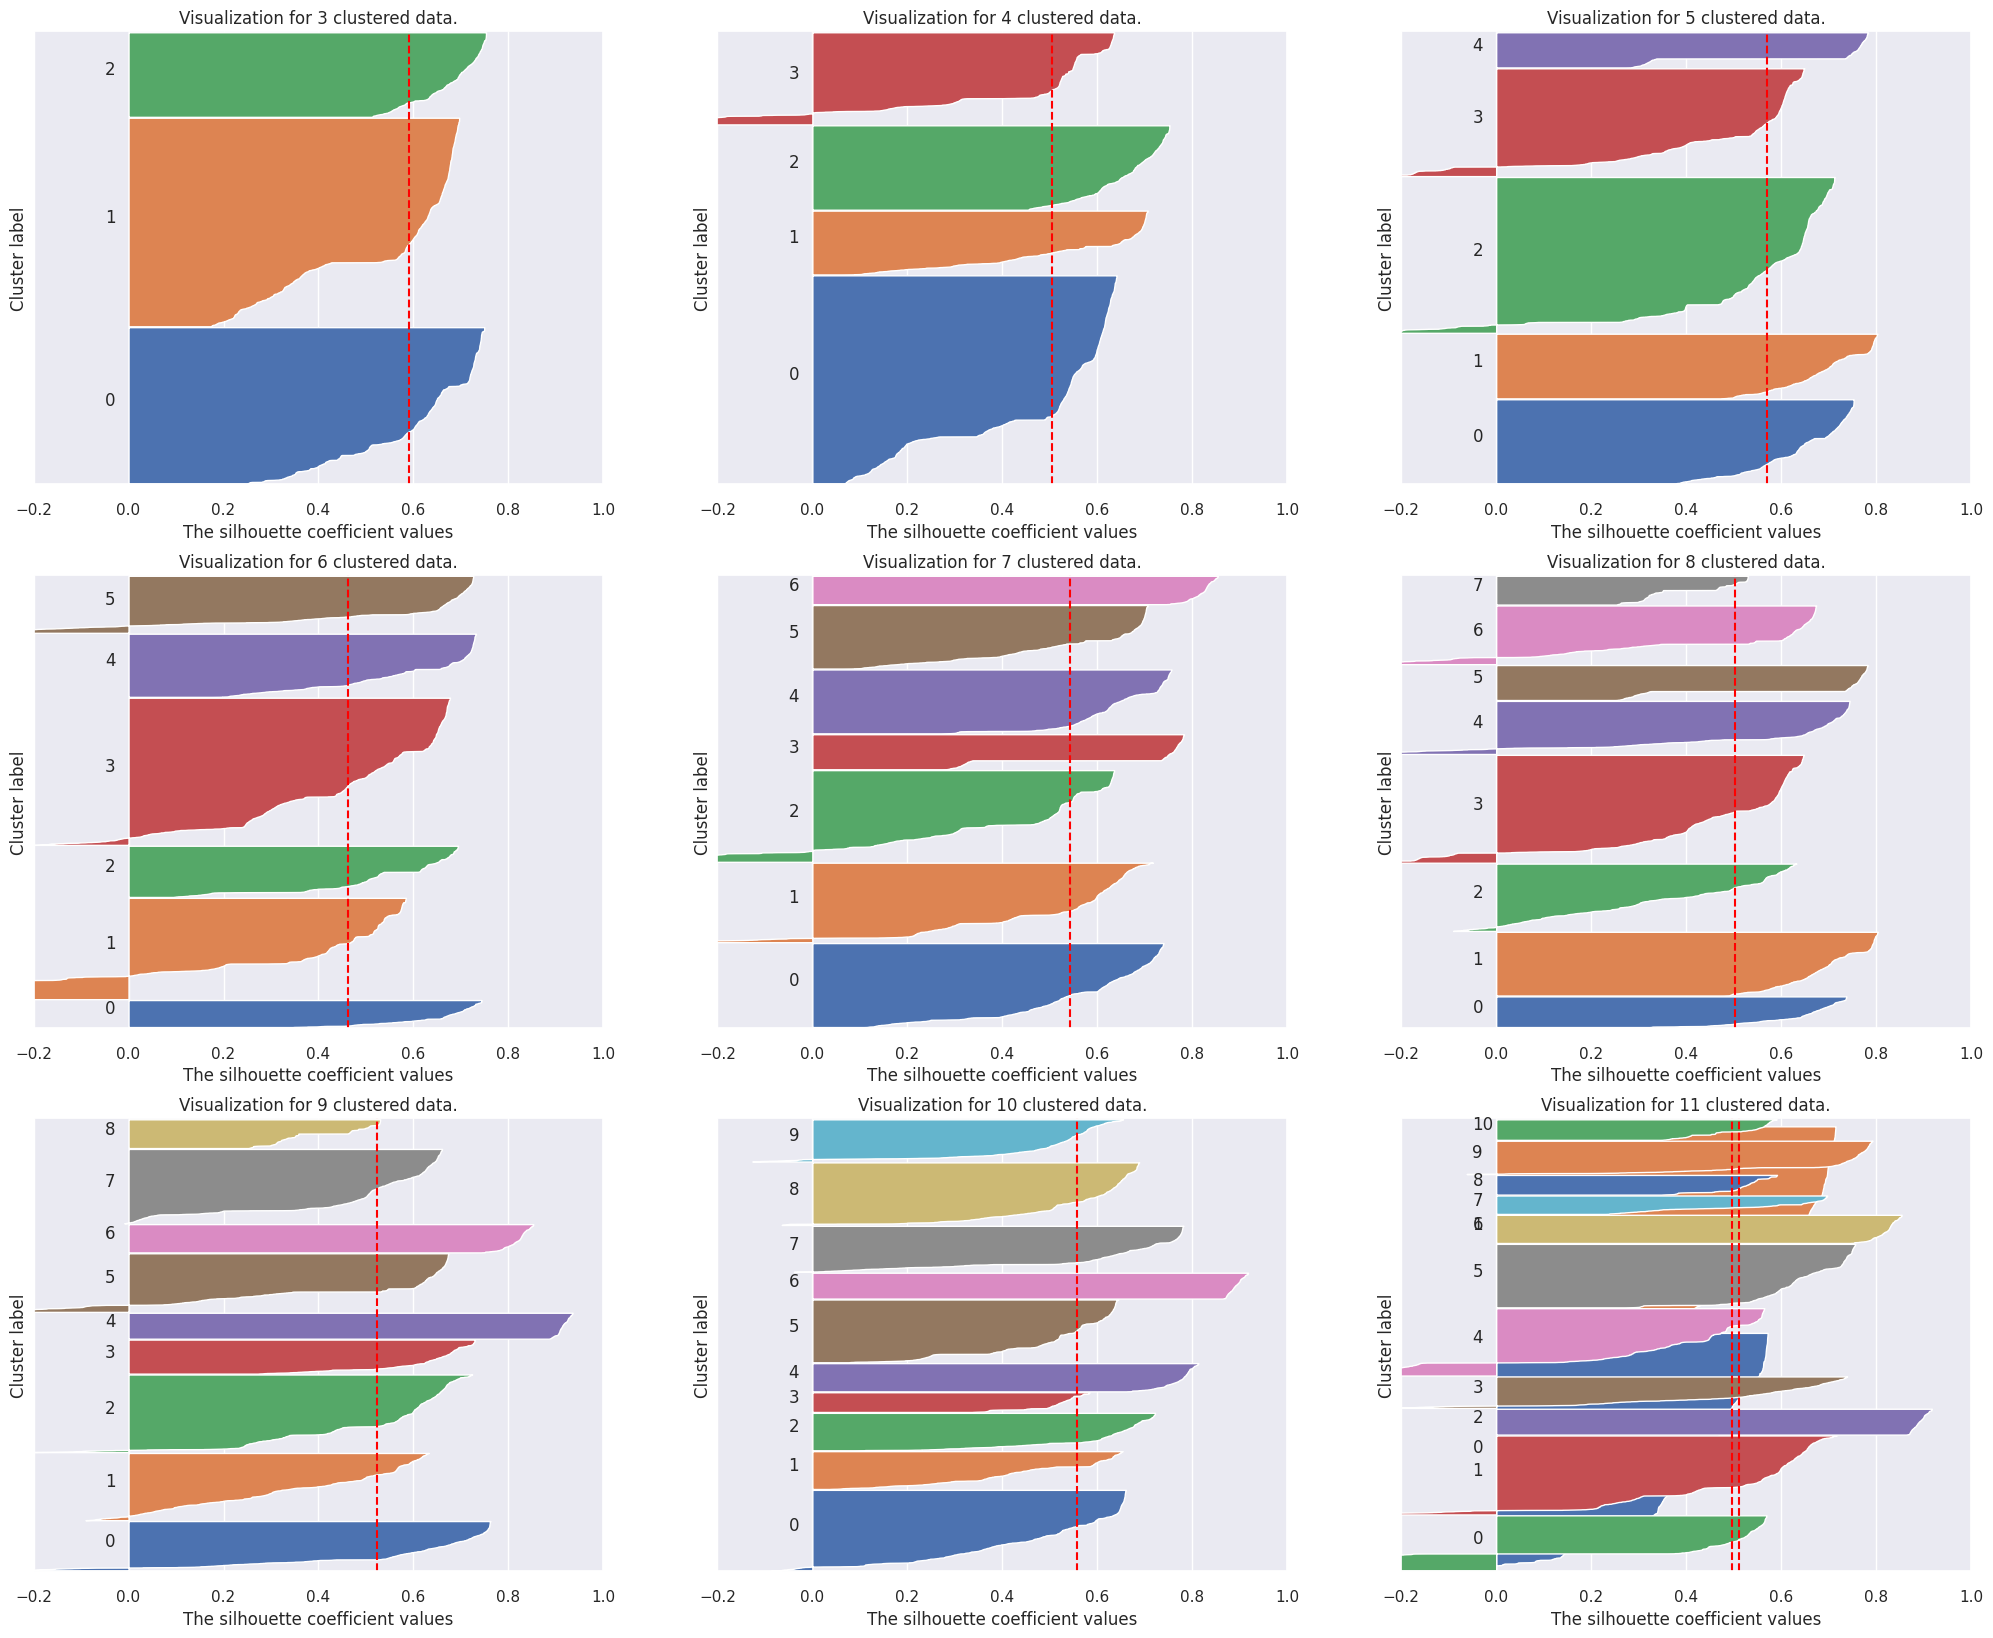

In [131]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(25, 20)

for k in clusters:
    q, mod = divmod(k, 3)
    
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(df7) + (k+1)*10])
    
    # Model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # Model training
    gmm_model.fit(df7)

    # Model predict
    labels = gmm_model.predict(df7)

    # Model performance
    ss = m.silhouette_score(df7, labels, metric='euclidean')
    print(f'For k: {k}. Silhouette Score: {ss}')
    
    samples_silhouette_values = m.silhouette_samples(df7, labels)
    
    y_lower = 10
    
    for i in range(k):
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)
        
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax[q-1, mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # The vertical line for average silhouette score of all the values
    ax[q-1, mod].axvline(x=ss, color="red", linestyle="--")
    
    ax[q-1, mod].set_title(f'Visualization for {k} clustered data.')
    ax[q-1, mod].set_xlabel("The silhouette coefficient values")
    ax[q-1, mod].set_ylabel("Cluster label")

### 7.6.3 H-Clustering

For k: 2. Silhouette Score: 0.4746178686618805
For k: 3. Silhouette Score: 0.5686032176017761
For k: 4. Silhouette Score: 0.5493912696838379
For k: 5. Silhouette Score: 0.4994887709617615
For k: 6. Silhouette Score: 0.5274532437324524
For k: 7. Silhouette Score: 0.5548451542854309
For k: 8. Silhouette Score: 0.5437556505203247
For k: 9. Silhouette Score: 0.5651723742485046
For k: 10. Silhouette Score: 0.5792537331581116
For k: 11. Silhouette Score: 0.5872927904129028


IndexError: index 3 is out of bounds for axis 0 with size 3

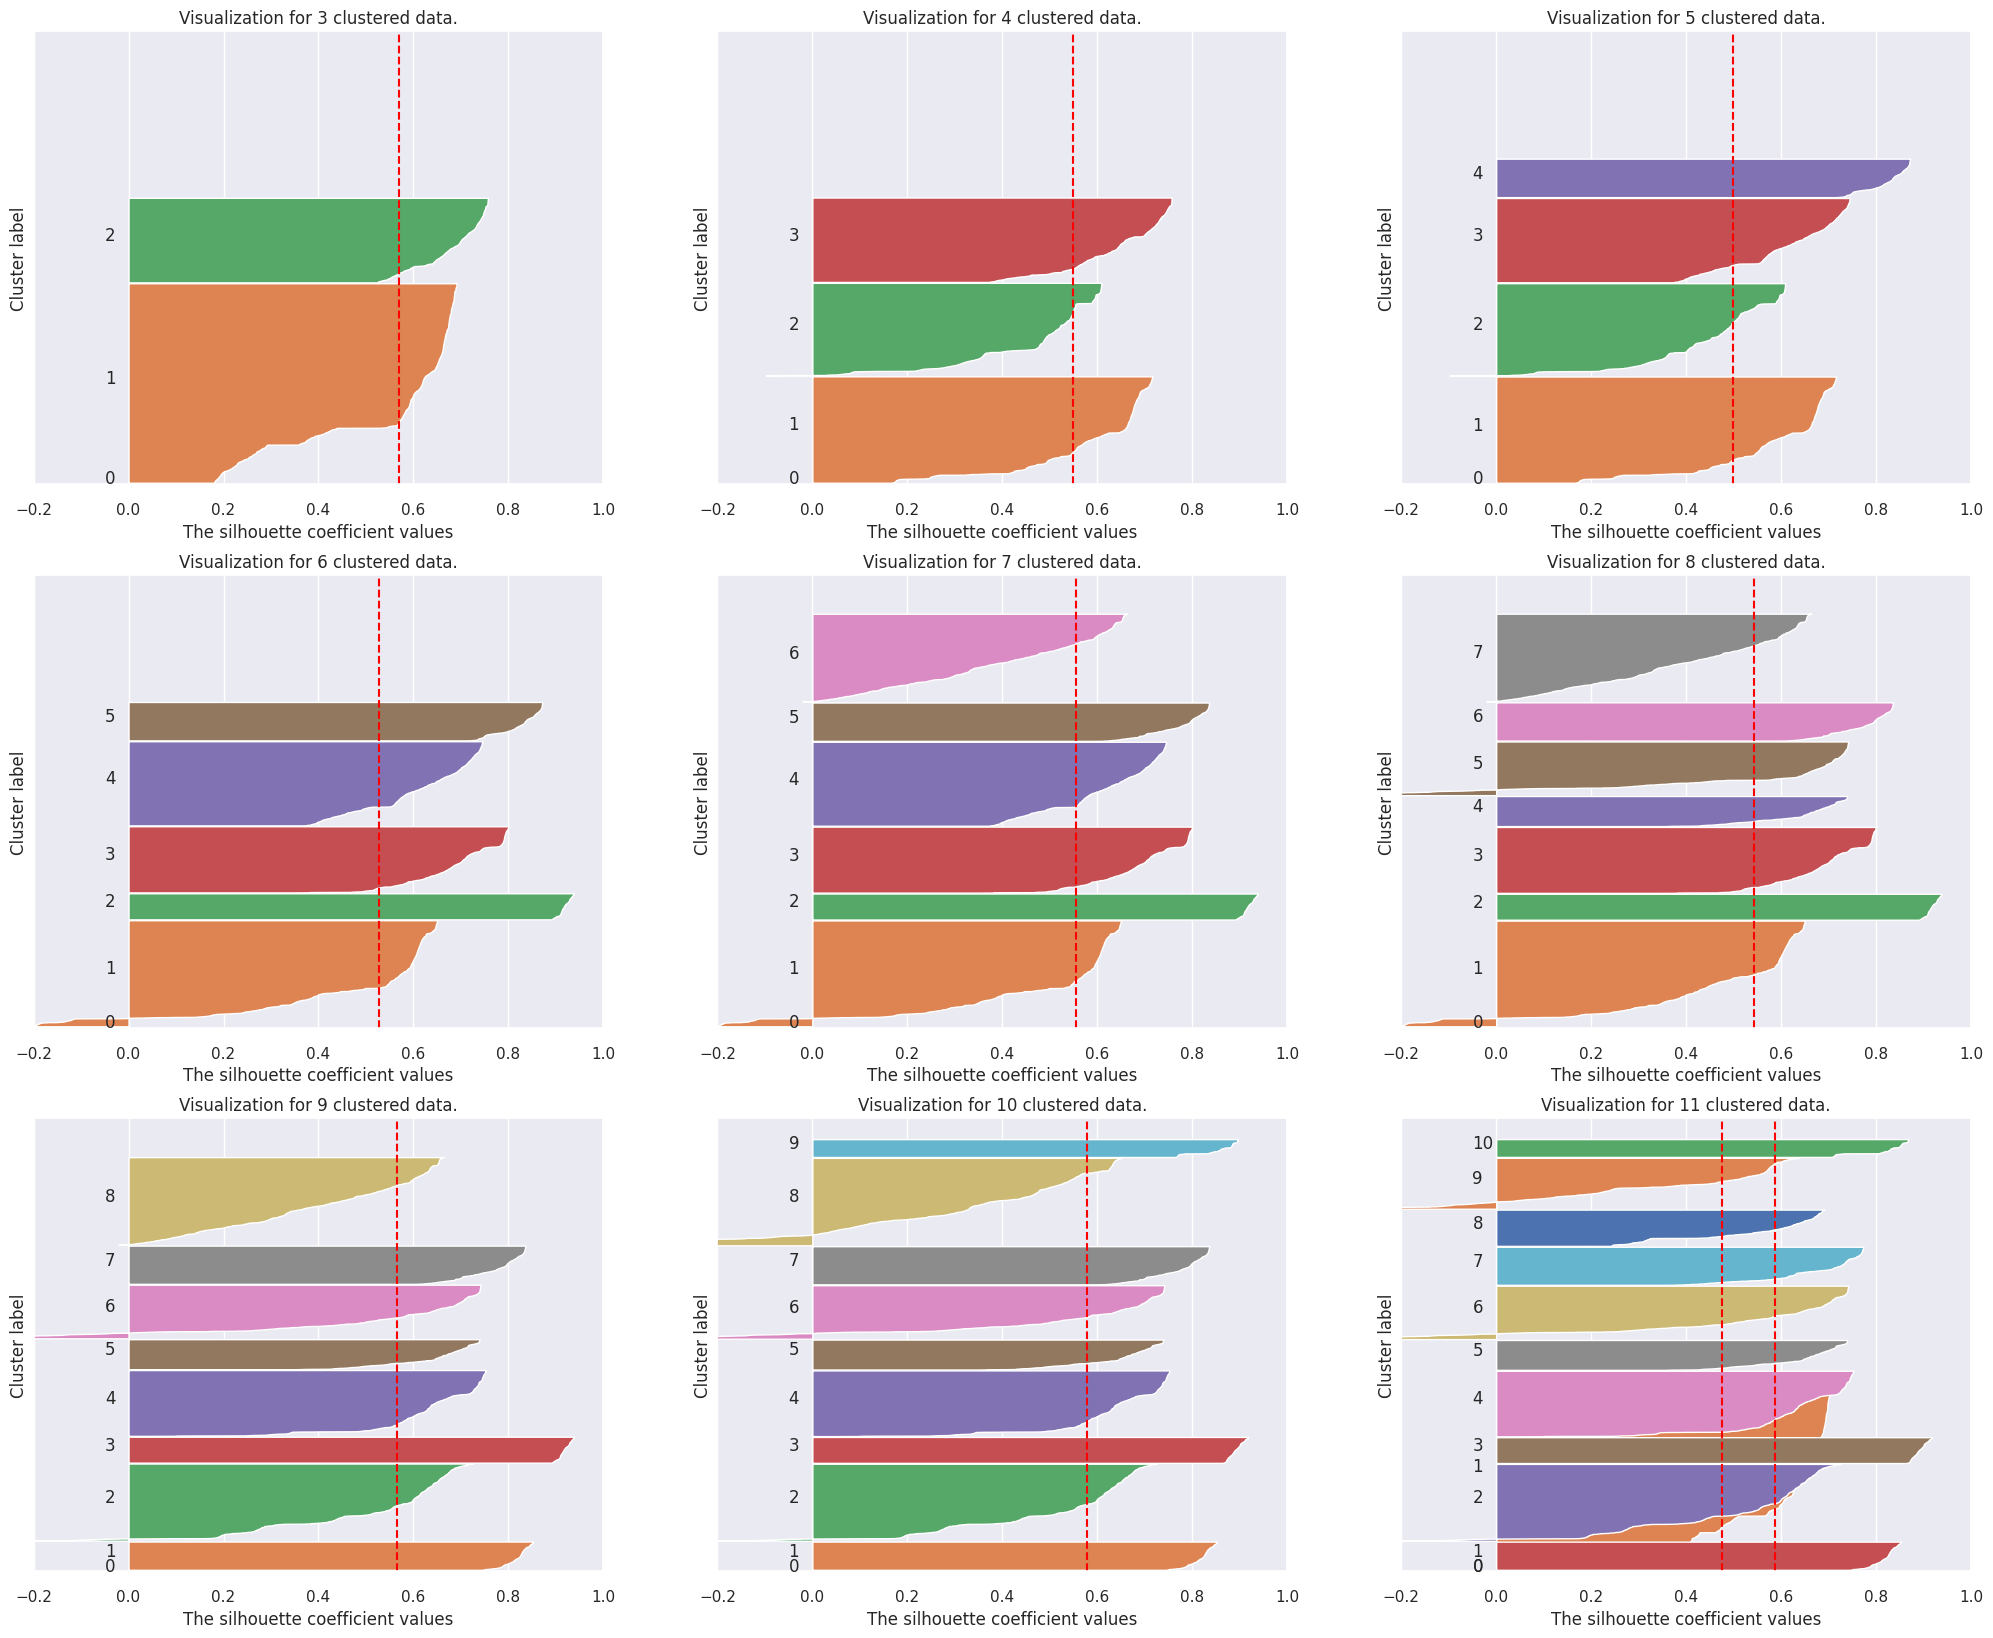

In [132]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(25, 20)

for k in clusters:
    q, mod = divmod(k, 3)
    
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(df7) + (k+1)*10])
    
    # model definition & training
    hc_model = hc.linkage(df7, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = m.silhouette_score(df7, labels, metric='euclidean')
    print(f'For k: {k}. Silhouette Score: {ss}')
    
    samples_silhouette_values = m.silhouette_samples(df7, labels)
    
    y_lower = 10
    
    for i in range(k):
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)
        
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax[q-1, mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # The vertical line for average silhouette score of all the values
    ax[q-1, mod].axvline(x=ss, color="red", linestyle="--")
    
    ax[q-1, mod].set_title(f'Visualization for {k} clustered data.')
    ax[q-1, mod].set_xlabel("The silhouette coefficient values")
    ax[q-1, mod].set_ylabel("Cluster label")

# 8.0 MODEL TRAINING

In [133]:
df8 = df7.copy()

## 8.1 K-Means

In [175]:
# Model definition
k = 9
kmeans = c.KMeans(init='random', n_clusters=k, n_init=300, max_iter=300, random_state=42)

# Model training
kmeans.fit(df8)

pickle.dump(kmeans, open('../src/model/kmeans_model.pkl', 'wb'))

# Clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [135]:
# WSS (Within-Cluster Sum of Squares)
print(f'WSS value: {kmeans.inertia_}')

# SS (Silhouette Score)
print('Silhouette Score: {}'.format(m.silhouette_score(df8, labels, metric='euclidean')))

WSS value: 33372.06640625
Silhouette Score: 0.585281252861023


# 9.0 CLUSTER ANALYSIS

In [136]:
df9_visualization = df8.copy()
df9_visualization['cluster'] = labels

df9 = df43 = df_ref[cols_selected].dropna().copy()
df9['cluster'] = labels

# Exporting datasets to csv for time saving
#df9.to_csv('../data/processed/clusters.csv', index=False)
#df9_visualization.to_csv('../data/processed/clusters_visualization.csv', index=False)
df9.head()

,customer_id,gross_revenue,qty_invoices,recency_days,qty_items,frequency,qty_returns,cluster
0,17850,5391.21,34.0,372.0,1733.0,17.000000,40.0,7
1,13047,3232.59,9.0,56.0,1390.0,0.028302,35.0,7
2,12583,6705.38,15.0,2.0,5028.0,0.040323,50.0,2
3,13748,948.25,5.0,95.0,439.0,0.017921,0.0,8
4,15100,876.00,3.0,333.0,80.0,0.073171,22.0,6


## 9.1 Visualization Inspection

/home/matheus/.pyenv/versions/3.8.12/envs/pa005/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


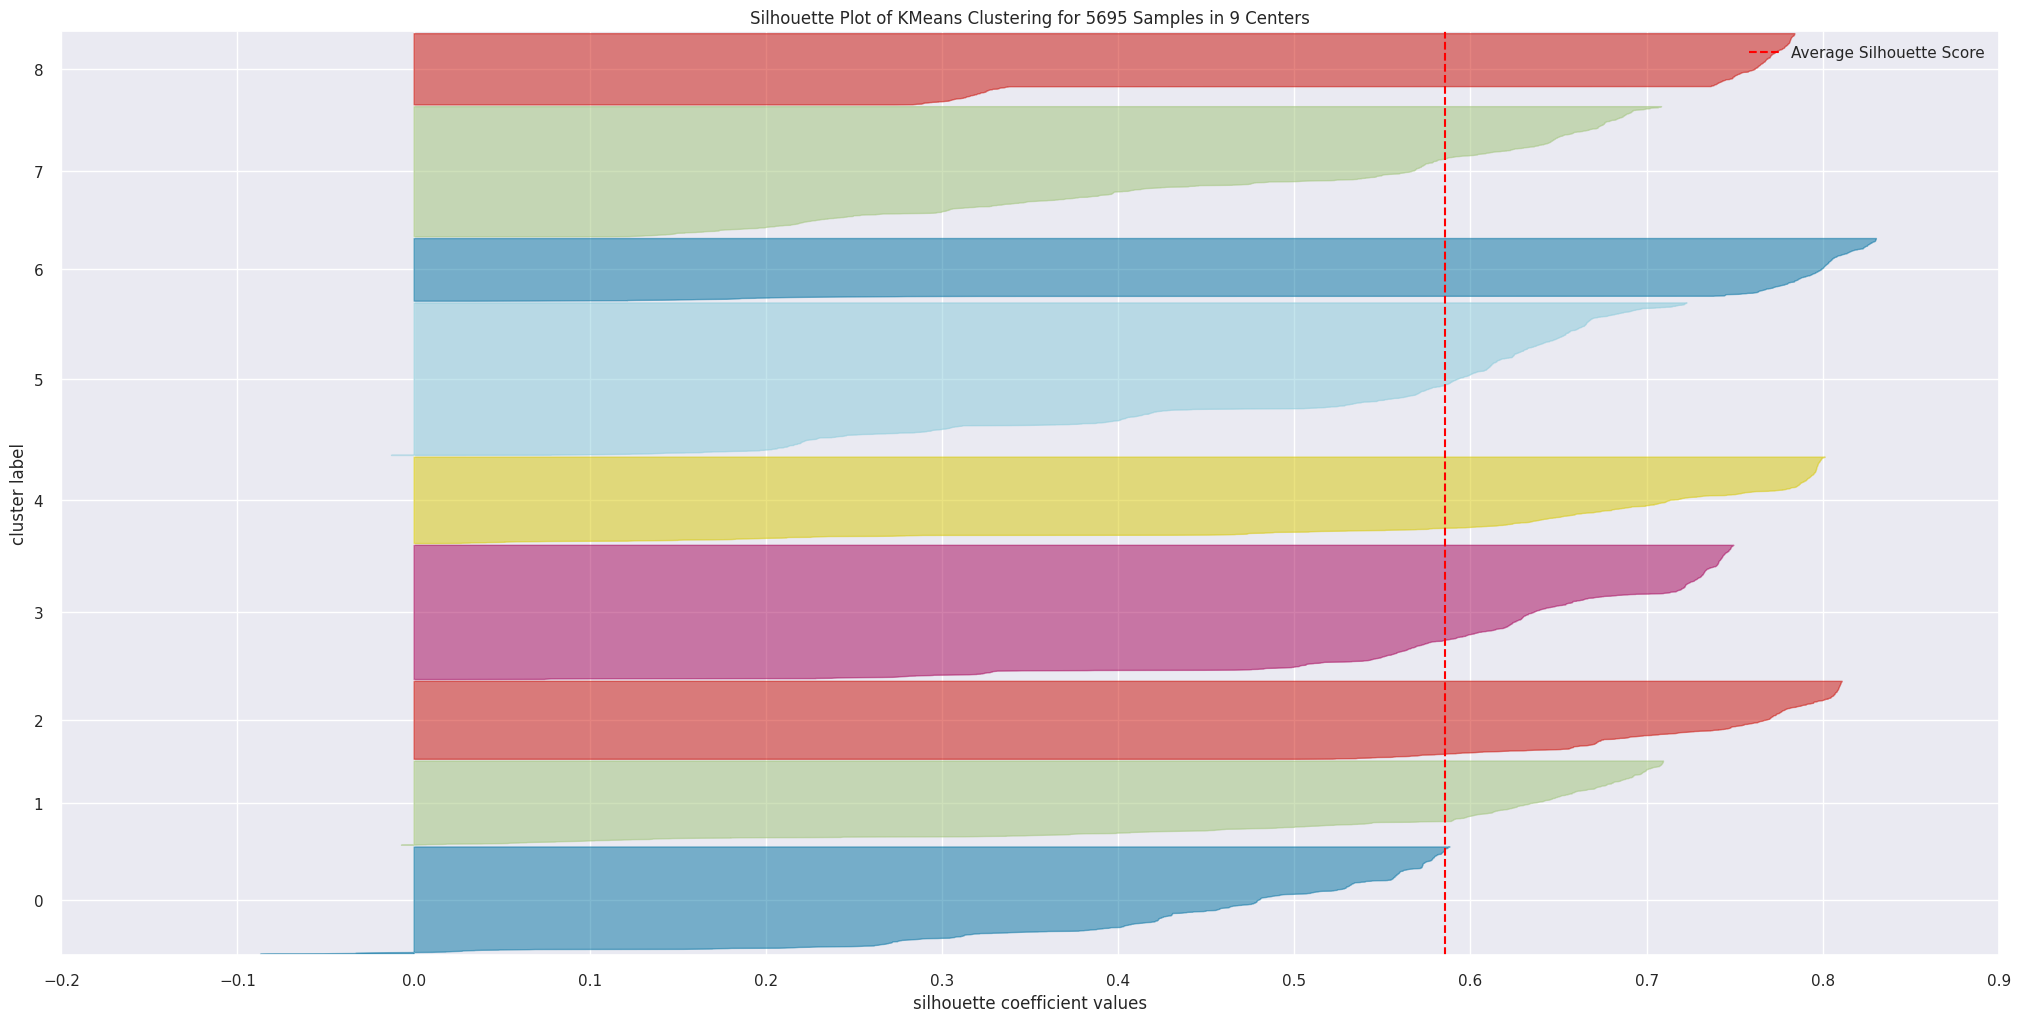

In [137]:
# Silhouette Analysis
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df8)
visualizer.finalize()

## 9.2 2d plot

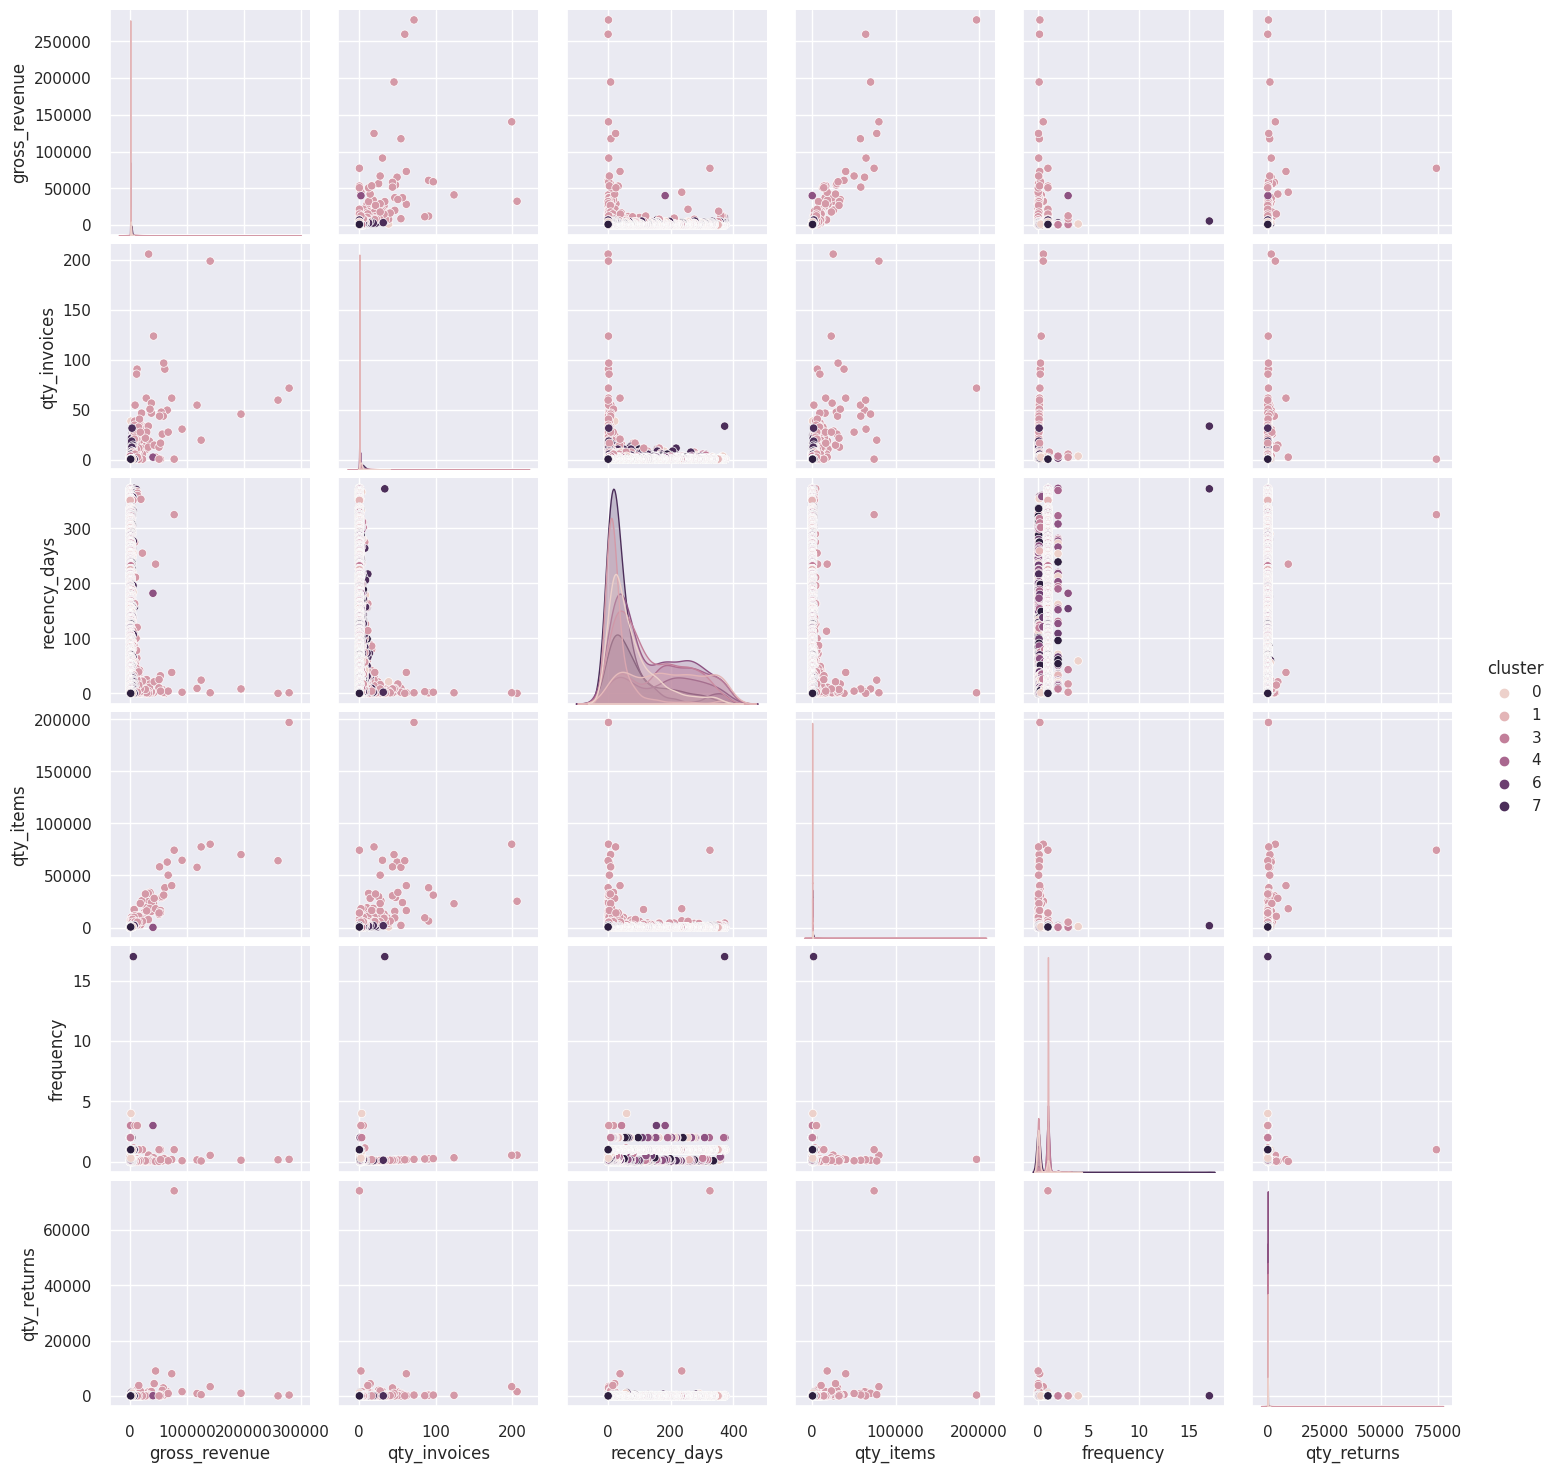

In [138]:
# Pair plot
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

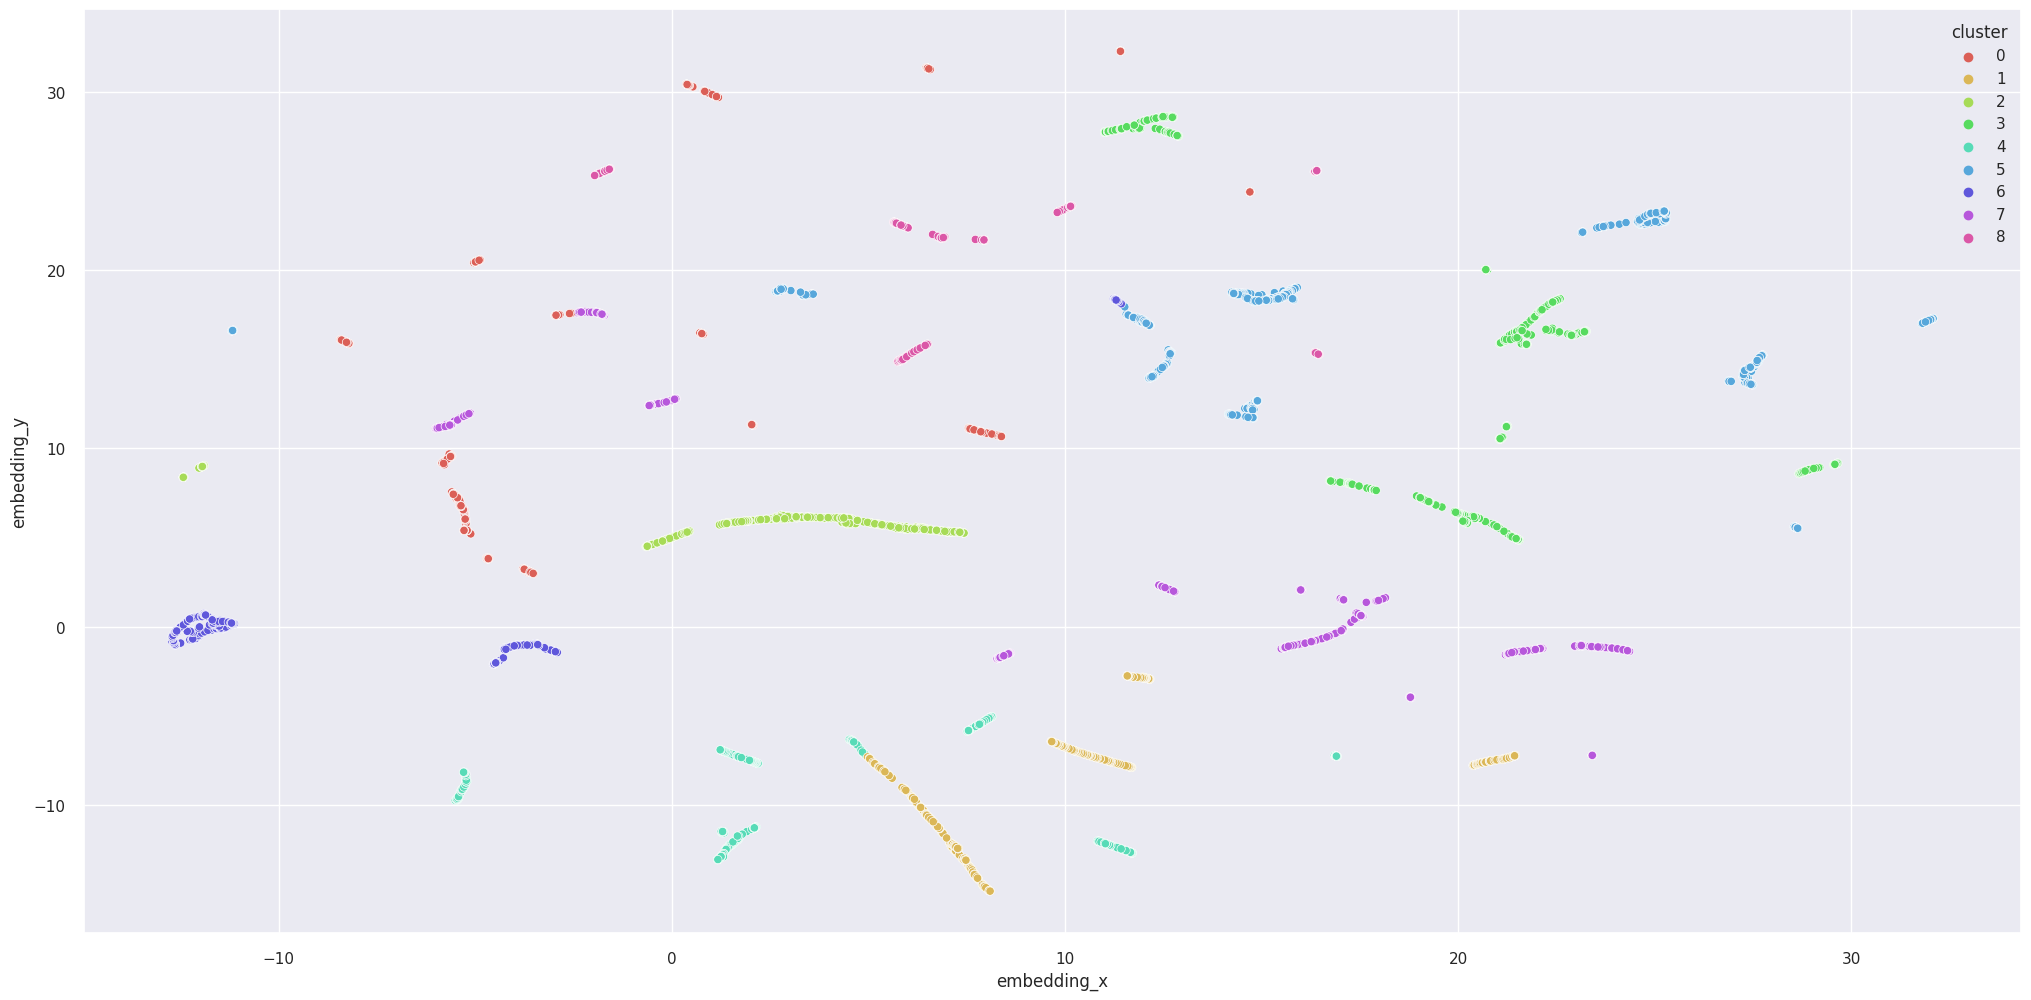

In [139]:
reducer = umap.UMAP(random_state=42, n_neighbors=100)
embedding = reducer.fit_transform(df8)

# Embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

## 9.2 Cluster Profile

In [2]:
df9 = pd.read_csv('../data/processed/clusters.csv')

In [3]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = df_cluster['customer_id']/df_cluster['customer_id'].sum()*100

# Avg Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg Recency Days
df_avg_recency_days= df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg Products quantity
df_avg_qty_items = df9[['qty_items', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_qty_items, how='inner', on='cluster')

# Frequency
df_avg_frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

# Returns
df_avg_qty_returns = df9[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_qty_returns, how='inner', on='cluster')


df_cluster['cluster_name'] = df_cluster['cluster'].apply(lambda x: 'Insiders' if x == 2 
                                                    else 'Leais' if x == 7
                                                    else 'Potenciais' if x == 0
                                                    else 'Novos' if x == 8
                                                    else 'Acompanhar' if x == 3
                                                    else 'Promissor' if x == 5
                                                    else 'Prestes a perder' if x == 6
                                                    else 'Perdendo' if x == 4
                                                    else 'Hibernando')

df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_items,frequency,qty_returns,cluster_name
2,2,490,8.604039,11107.459796,30.708163,6588.055102,0.114432,299.157143,Insiders
7,7,817,14.345917,2457.463195,53.003672,1309.271726,0.174806,20.171359,Leais
0,0,674,11.834943,1378.246973,75.934718,705.854599,0.266081,10.556380,Potenciais
8,8,448,7.866550,999.629821,90.082589,454.854911,0.307258,5.323661,Novos
3,3,843,14.802458,788.741886,129.404508,330.926453,0.677251,2.613286,Acompanhar
5,5,957,16.804214,416.425141,137.740857,169.624869,0.692654,2.199582,Promissor
6,6,394,6.918349,275.352132,177.593909,91.332487,0.838796,0.901015,Prestes a perder
4,4,543,9.534680,166.163591,194.082873,47.616943,0.939700,0.985267,Perdendo
1,1,529,9.288850,28.346238,188.568998,6.274102,0.995130,0.582231,Hibernando


### Cluster 6: Insiders
    - Número de customers: 490 (8,6% dos costumers)
    - Receita: 11107,50
    - Recência em média: 31 dias
    - Quantidade média de itens comprados: 6588
    - Frequência de compra: 0,11
    - Quantidade média de produtos retornados: 299

# 10. ANÁLISE EXPLORATÓRIA DE DADOS

In [30]:
df10 = df9.copy()

# Label for each cluster
df10['cluster_name'] = df10['cluster'].apply(lambda x: 'Insiders' if x == 2 
                                                    else 'Leais' if x == 7
                                                    else 'Potenciais' if x == 0
                                                    else 'Novos' if x == 8
                                                    else 'Acompanhar' if x == 3
                                                    else 'Promissor' if x == 5
                                                    else 'Prestes a perder' if x == 6
                                                    else 'Perdendo' if x == 4
                                                    else 'Hibernando')


## 10.1 MindMap de Hipóteses

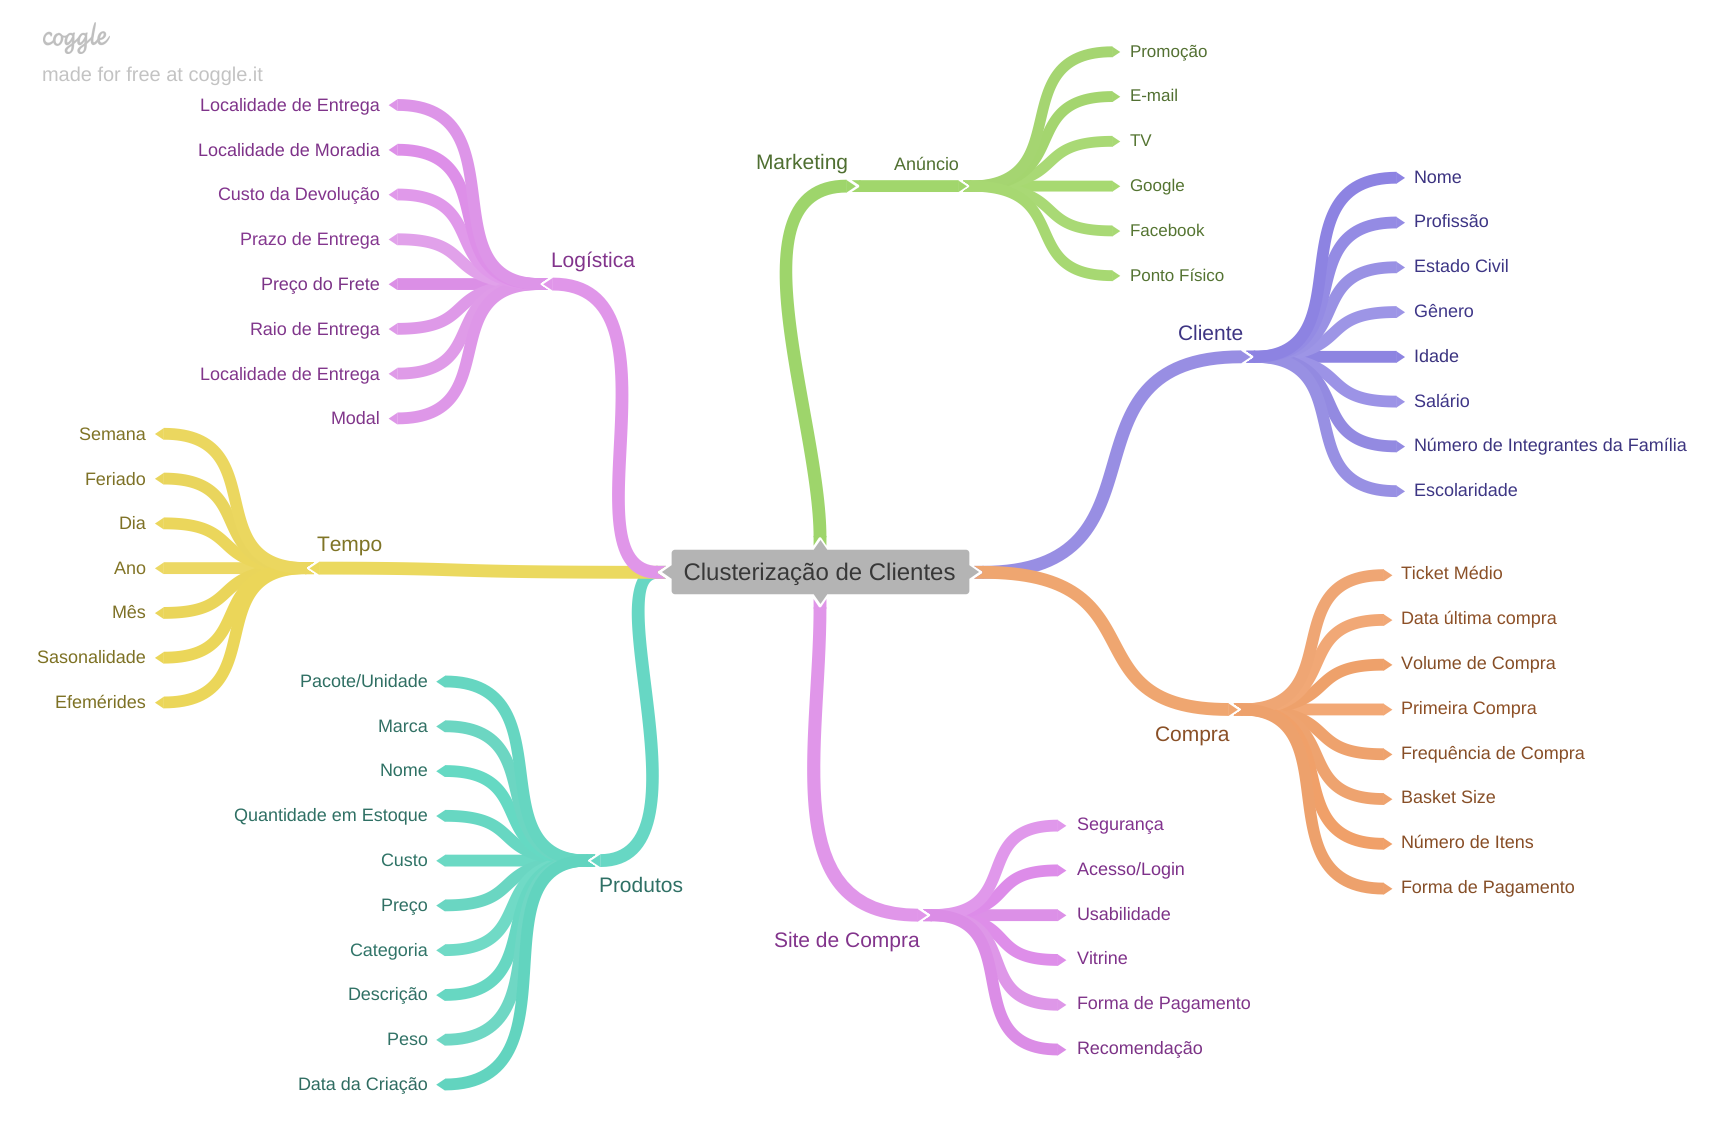

In [142]:
Image('../img/MindMapHypothesis.png')

## 10.2 Hipóteses de Negócio

### Hipóteses Compra

1. Os clientes do cluster Insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster Insiders possuem um Ticket Médio de 10% acima do cluster More Products.
3. Os clientes do cluster Insiders possuem um Basket Size acima de 5 produtos.
4. **Os clientes do cluster Insiders possuem um volume (produtos) de compras acima de 10% do total de compras.**
5. **Os clientes do cluster Insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.**
6. **Os clientes do cluster Insiders possuem um número de devolução abaixo da média da base total de clientes.**
7. **A mediana do faturamento pelos clientes do cluser Insiders é 10% maior do que a mediana do faturamento geral.**
8. **O percentil do gmv pelos clientes Insiders.**

### Hipóteses Cliente

1. 60% dos clientes do cluster Insiders possuem o estado civil de solteiro.
2. 10% dos clinetes do cluster Insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do cluster Insiders estão dentro de um raio de 50km.
4. 10% das localidades de entrega do cluster Insiders estão dentro do Reino Unido.
5. 5% dos clientes do cluster Insiders recebem mais de 100 mil libras anualmente.
6. 90% dos clientes do cluster Insiders têm ensino superior completo.

### Hipóteses Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster Insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster Insiders é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos clientes Insiders é maior que a mediana.
4. O peso médio dos produtos comprados pelos clientes do cluster Insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster Insiders é menor do que 15 dias.

## 10.3 Priorização das Hipóteses

#### H1. Os clientes do cluster Insiders possuem um volume (produtos) de compras acima de 10% do total de compras.*
**VERDADEIRA**. O cluster Insiders possuem um volume de compra de produtos de 58,87%

In [143]:
# sum of quantity of products from Insiders
df_sales_insiders = df10.loc[df10['cluster'] == 2, 'qty_items'].sum()

# total quantity of producst
df_sales_total = df10.loc[:, 'qty_items'].sum()

print(f'% Sales Insiders: {100*df_sales_insiders/df_sales_total:.2f}%')

% Sales Insiders: 58.87%


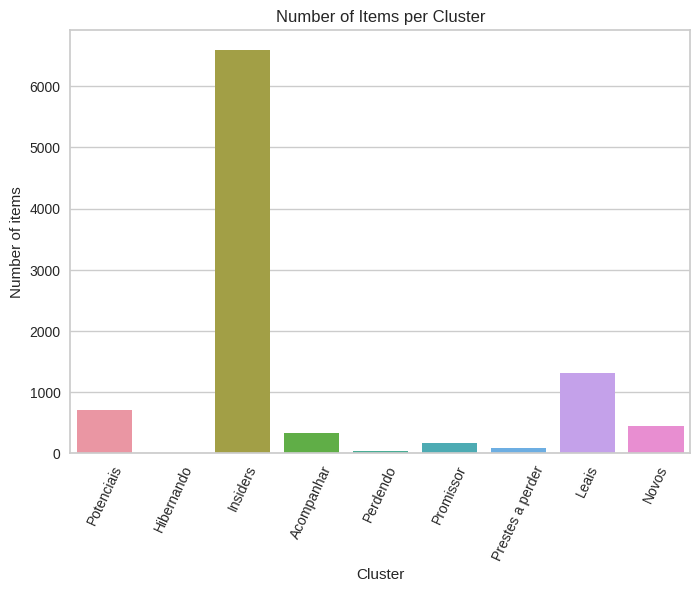

In [27]:
ax = sns.barplot(y='qty_items', x='cluster_name', data=df_cluster)
plt.xlabel('Cluster')
plt.ylabel('Number of items')
plt.title('Number of Items per Cluster')
plt.xticks(rotation=65);

#### H2. Os clientes do cluster Insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.
**VERDADEIRA**. O cluster Insiders possui um volume de GMV de 53,86%.

In [144]:
# gross revenue from Insiders
df_gvm_insiders = df10.loc[df10['cluster'] == 2, 'gross_revenue'].sum()

# total gross revenue
df_gvm_total = df10.loc[:, 'gross_revenue'].sum()

print(f'% Sales Insiders: {100*df_gvm_insiders/df_gvm_total:.2f}%')

% Sales Insiders: 53.86%


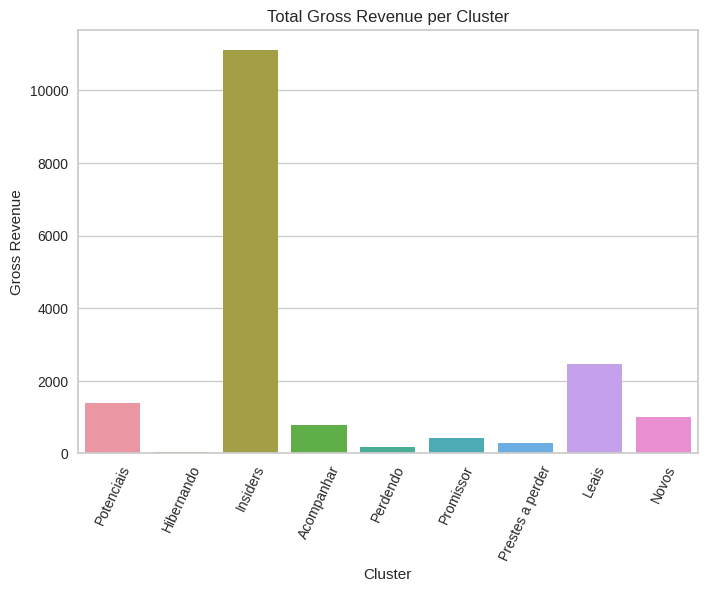

In [26]:
ax = sns.barplot(y='gross_revenue', x='cluster_name', data=df_cluster)
plt.xlabel('Cluster')
plt.ylabel('Gross Revenue')
plt.title('Total Gross Revenue per Cluster')
plt.xticks(rotation=65);

#### H3. Os clientes do cluster Insiders possuem um número de devolução abaixo da média da base total de clientes.
**FALSA**. O cluster Insiders tem média de devoluções acima da média geral.

In [145]:
# mean of returns from cluster Insiders
df_avg_insiders = df10.loc[df10['cluster'] == 2, 'qty_returns'].mean()

# mean of returns for total database
df_avg_returns_total = df10['qty_returns'].mean()

print(f'Average Returns Insiders: {df_avg_insiders:.0f} vs Average Returns All: {df_avg_returns_total:.0f}')

Average Returns Insiders: 299 vs Average Returns All: 31


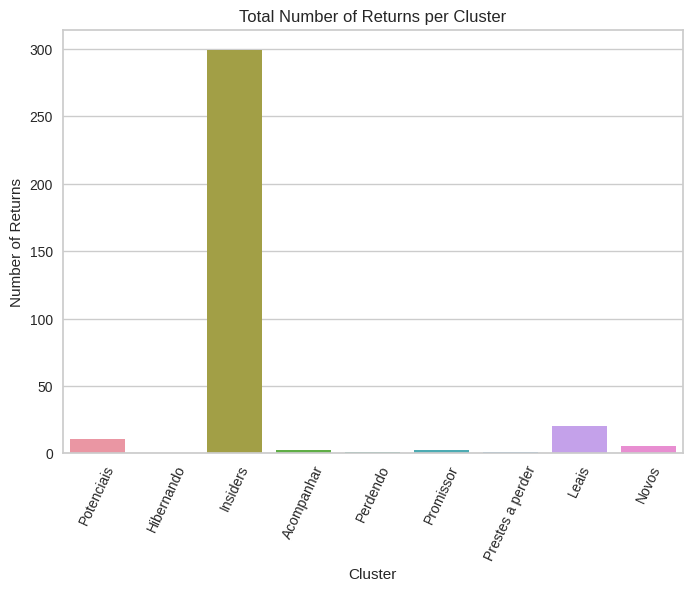

In [28]:
ax = sns.barplot(y='qty_returns', x='cluster_name', data=df_cluster)
plt.xlabel('Cluster')
plt.ylabel('Number of Returns')
plt.title('Total Number of Returns per Cluster')
plt.xticks(rotation=65);

#### H4. A mediana do faturamento pelos clientes do cluser Insiders é 10% maior do que a mediana do faturamento geral.
**FALSA**. A mediana do faturamento do cluster Insiders é 781,46 vezes maior.

In [31]:
# median gmv from Insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 2, 'gross_revenue'].median()

# median gmv total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = ((df_median_gmv_insiders - df_median_gmv_total)/df_median_gmv_total)
print(f'Median Diff: {gmv_diff*100:.2f}%')

Median Diff: 781.46%


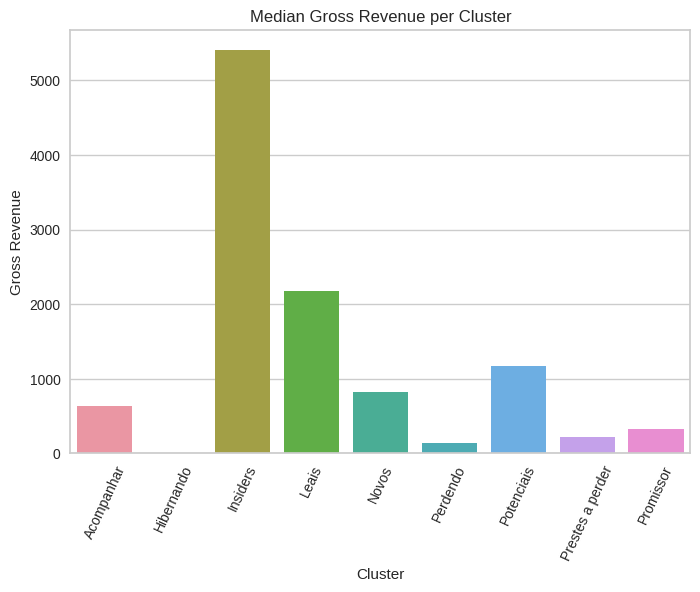

In [41]:
aux = df10[['gross_revenue', 'cluster_name']].groupby('cluster_name').median().reset_index()
sns.barplot(aux, y='gross_revenue', x='cluster_name')
plt.xlabel('Cluster')
plt.ylabel('Gross Revenue')
plt.title('Median Gross Revenue per Cluster')
plt.xticks(rotation=65);

#### H5. O GMV dos clientes Insiders estão concentrados no 3º quartil.
**FALSO**. O faturamento do cluster Insiders está concentrado no 1º quartil.

<AxesSubplot: >

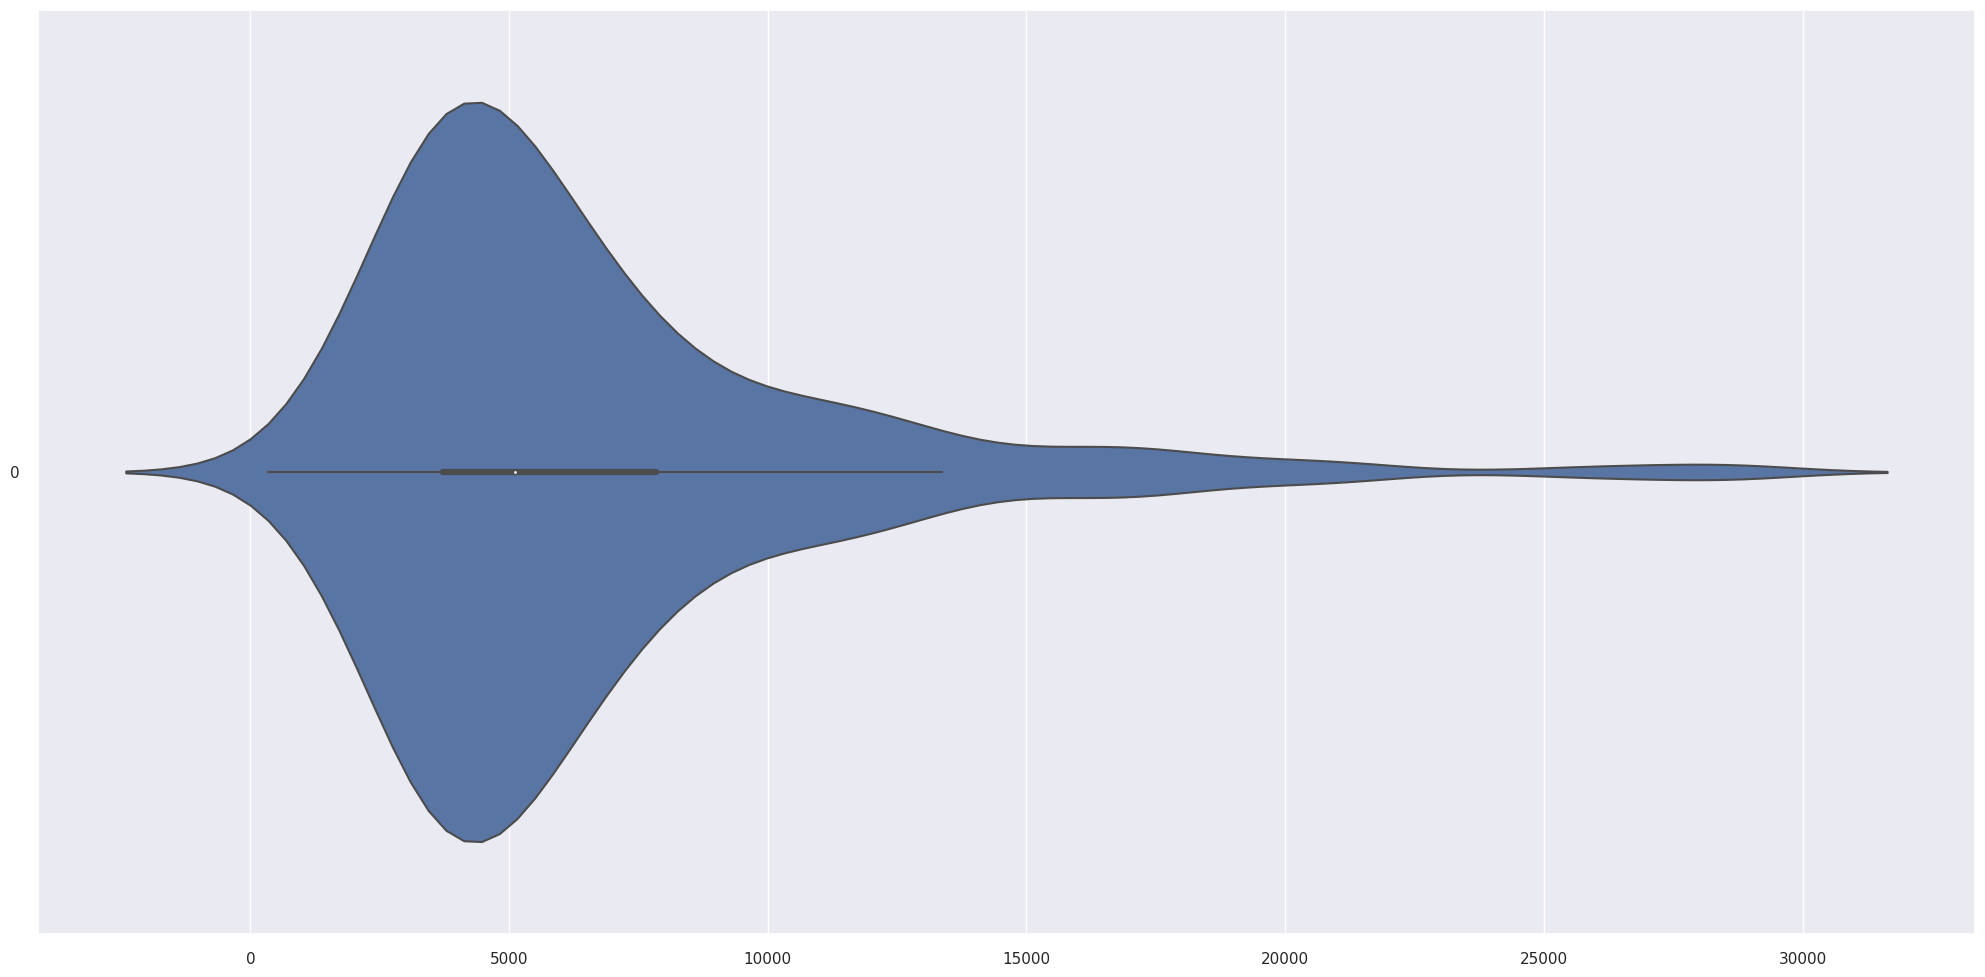

In [150]:
sns.violinplot(df10.loc[(df10['cluster'] == 2) & (df10['gross_revenue'] < 30000), 'gross_revenue'].values, orient='h')

In [99]:
df10.loc[df10['cluster'] == 2, 'gross_revenue'].values

array([6.705380e+03, 9.482500e+02, 5.630870e+03, 6.382450e+03,
       7.118600e+02, 1.722036e+04, 1.475822e+04, 6.831300e+02,
       7.930540e+03, 2.107630e+04, 8.234200e+02, 8.002400e+02,
       1.337587e+04, 1.198230e+03, 6.068110e+03, 1.015500e+02,
       7.832470e+03, 1.658709e+04, 1.202165e+04, 1.808500e+02,
       1.027900e+02, 1.308610e+03, 2.440800e+02, 8.694260e+03,
       4.690310e+03, 1.742405e+04, 6.776560e+03, 6.127430e+03,
       4.183390e+03, 6.140420e+03, 3.546710e+03, 4.812420e+03,
       5.762600e+02, 4.006940e+03, 1.104504e+04, 1.251566e+04,
       6.975500e+02, 1.728686e+04, 1.118991e+04, 3.907010e+03,
       4.476400e+02, 5.601340e+03, 3.339700e+02, 2.002400e+03,
       4.597020e+03, 1.660900e+03, 5.509120e+03, 5.156200e+02,
       1.199096e+04, 1.102822e+04, 6.922200e+02, 8.668450e+03,
       8.816400e+03, 8.052970e+03, 4.436120e+03, 4.339740e+03,
       1.659435e+04, 4.604220e+03, 6.499200e+03, 5.346230e+03,
       1.554300e+02, 8.609280e+03, 5.333300e+02, 5.6514

## 10.4 Perguntas de Negócio

### **1. Quem são as pessoas elegíveis para participar do programa de Insiders?**

In [151]:
df10.loc[df10['cluster'] == 2, 'customer_id'].head()

2    12583
5    15291
6    14688
7    17809
8    15311
Name: customer_id, dtype: int64

### **2. Quantos clientes farão parte do grupo?**

O cluster Insiders é formado por 490 clientes.

In [152]:
df10.loc[df10['cluster'] == 2, 'customer_id'].size

490

### **3. Quais as principais características desses clientes?**

    - Número de customers: 490 (8,6% dos costumers)
    - Receita: 11107,50
    - Recência em média: 31 dias
    - Quantidade média de itens comprados: 6588
    - Frequência de compra: 0,11
    - Quantidade média de produtos retornados: 299

In [153]:
df_cluster[df_cluster['cluster'] == 2]

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_items,frequency,qty_returns
2,2,490,8.604039,11107.459796,30.708163,6588.055102,0.114432,299.157143


### **4. Qual a porcentagem de contribuição do faturamento, vinda dos Insiders?**

In [154]:
# gmv from Insiders
df_insiders_gmv = df10.loc[df10['cluster'] == 2, 'gross_revenue'].sum()

# total gmv
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print(f'% GMV from Insiders: {100*df_insiders_gmv/df_all_gmv:.2f}')

% GMV from Insiders: 53.86


###  **5. Qual a expectativa de faturamento desse grupo para os próximos meses?**
Para responder essa pergunta seria interessante analisar o cluster Insiders formado ao longo dos meses
e observar o faturamento para se determinar um padrão, como por exemplo, utilizando séries temporais.

### 6.Quais as condições para uma pessoa ser elegível ao Insiders?
### 7. Quais as condições para uma pessoa ser removida dos Insiders?

As condições serão o monitoramento dos clusters ao longo do tempo, e acompanhamento dos clientes, quais entraram e quais saíram do cluster Insiders.

### 8. Qual a garantia que o programa Insiders é melhor que o restante da base?

### 9. Quais ações o time de Marketing pode tomar para aumentar o faturamento?

# 11.0 DEPLOY TO PRODUCTION

In [35]:
# Label for each cluster
df10['cluster_name'] = df10['cluster'].apply(lambda x: 'Insiders' if x == 2 
                                                    else 'Leais' if x == 7
                                                    else 'Potenciais' if x == 0
                                                    else 'Novos' if x == 8
                                                    else 'Acompanhar' if x == 3
                                                    else 'Promissor' if x == 5
                                                    else 'Prestes a perder' if x == 6
                                                    else 'Perdendo' if x == 4
                                                    else 'Hibernando')

df10.head()

,customer_id,gross_revenue,qty_invoices,recency_days,qty_items,frequency,qty_returns,cluster,cluster_name
0,17850,5391.21,34.0,372.0,1733.0,17.000000,40.0,7,Leais
1,13047,3232.59,9.0,56.0,1390.0,0.028302,35.0,7,Leais
2,12583,6705.38,15.0,2.0,5028.0,0.040323,50.0,2,Insiders
3,13748,948.25,5.0,95.0,439.0,0.017921,0.0,8,Novos
4,15100,876.00,3.0,333.0,80.0,0.073171,22.0,6,Prestes a perder


## 11.1 Insert into SQLite

In [171]:
# # Create Table
# query_create_table_insiders = """
#     CREATE TABLE insiders(
#         customer_id   INTEGER,
#         gross_revenue REAL,
#         recency_days  INTEGER,
#         qty_products  INTEGER,
#         frequency     REAL,
#         qty_returns   INTEGER,
#         cluster       INTEGER,
#         cluster_name  TEXT
#     )      
# """

# conn = sqlite3.connect('insiders_db.sqlite')
# conn.execute(query_create_table_insiders)
# conn.commit()
# conn.close()

# Insert Data
conn = create_engine('sqlite:///insiders_db.sqlite')

df10.to_sql('insiders', con=conn, if_exists='replace', index=False)

5695

In [172]:
# Consulting Database
query = """
    SELECT * FROM insiders
"""

conn = create_engine('sqlite:///insiders_db.sqlite')

df =pd.read_sql_query(con=conn.connect(), sql=query)

In [173]:
df

,customer_id,gross_revenue,qty_invoices,recency_days,qty_items,frequency,qty_returns,cluster,cluster_name
0,17850,5391.21,34.0,372.0,1733.0,17.000000,40.0,7,Leais
1,13047,3232.59,9.0,56.0,1390.0,0.028302,35.0,7,Leais
2,12583,6705.38,15.0,2.0,5028.0,0.040323,50.0,2,Insiders
3,13748,948.25,5.0,95.0,439.0,0.017921,0.0,8,Novos
4,15100,876.00,3.0,333.0,80.0,0.073171,22.0,6,Prestes a perder
...,...,...,...,...,...,...,...,...,...
5690,22706,5699.00,1.0,1.0,1747.0,1.000000,0.0,7,Leais
5691,22707,6756.06,1.0,0.0,2010.0,1.000000,0.0,7,Leais
5692,22708,3217.20,1.0,0.0,654.0,1.000000,0.0,0,Potenciais
5693,22709,3950.72,1.0,0.0,731.0,1.000000,0.0,0,Potenciais
